# Popularidade positiva do presidente

Este notebook é usado para atualizar os resultados de popularidade do modelo para o presidente da República quando uma nova nova observação é registrada na base de dados de pesquisas de opinião. Assim, nós conseguimos validadar a pesquisa rapidamente, ajustar o modelo, executar diagnósticos de validade do modelo e exportar os dados para o dashboard.

**Vez ou outra, nós também executamos algumas analises sobre as diferenças entre o modelo mais recente do anterior, antes de incluir uma nova observação.**

In [189]:
import sys
import os
try:
    import warnings                                                   
    warnings.filterwarnings('ignore')     
    import pandas as pd       
    import numpy as np
    import sqlite3
    import watermark
    import pymc3 as pm
    import xarray as xr
    import arviz as az
    import theano.tensor as aet
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cbook as cbook
    from scipy.special import expit as logistic
    from IPython.display import display, HTML
    from dateutil.relativedelta import relativedelta

except ImportError:
    print("Error: missing one of the libraries..")
    sys.exit()

sys.path.append('../..')
    
from model_utils import *


# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print(os.getcwd())
print(sys.argv[0])
print(os.path.dirname(os.path.realpath('__file__')))
print('Running on pymc3 v{}'.format(pm.__version__))
print('Running on arviz v{}'.format(az.__version__))

/Users/marcelino/dmarcelinobr/pollbase/dashboards/notebooks
/Users/marcelino/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py
/Users/marcelino/dmarcelinobr/pollbase/dashboards/notebooks
Running on pymc3 v3.11.4
Running on arviz v0.11.2


## Carrega os dados

In [205]:
con = sqlite3.connect('../../pollingpoints.db')

aprovacao = pd.read_sql(""" SELECT 
data_fim, empresa, nome, positiva, regular, negativa, amostra, erro, presidente, modo 
FROM popularidade WHERE tipo = "Avaliação do governo federal"
ORDER BY data_fim; """, con=con) 

# AND empresa = "Vox Populi"
con.close()

## Limpa e ajusta os dados

In [206]:
# Converte para datetime 
aprovacao["data_fim"] = pd.to_datetime(aprovacao["data_fim"])

# Index by field date
aprovacao.set_index("data_fim", inplace=True)

# sort by field date
aprovacao = aprovacao.sort_index(axis=0)

# Filter data to the time spam  
# aprovacao = aprovacao.loc[aprovacao.index >= pd.to_datetime("1990-01-01")]

# Filter data to full term presidents
# aprovacao = aprovacao.loc[aprovacao.presidente != "Dilma Rousseff II"]
# aprovacao = aprovacao.loc[aprovacao.presidente != "Michel Temer"]

aprovacao["ano"] = aprovacao.index.year
aprovacao["mes"] = aprovacao.index.month
aprovacao["semana"] = aprovacao.index.week

# Correct a few typos in the dataset
# aprovacao["empresa"] = aprovacao["empresa"].replace("DEIA Big Data", "DEIA")
aprovacao["modo"] = aprovacao["modo"].replace("Online", "Internet")
aprovacao["modo"] = aprovacao["modo"].replace("FF", "Presencial")

# Convert approvals rates to proportion and compute total num approval
aprovacao[["positiva", "regular", "negativa"]] = (
    aprovacao[["positiva", "regular", "negativa"]].copy() / 100
)
# aprovacao = aprovacao.rename(columns={"positiva": "idx_aprova", "regular": "idx_neutro", "negativa": "idx_reprova"})

# Replace NA with 1000 interviews 
aprovacao["amostra"] = aprovacao["amostra"].replace(np.nan, 1000)
aprovacao["amostra"] = aprovacao["amostra"].astype("int") 
aprovacao["positiva_int"] = np.floor(aprovacao["amostra"] * aprovacao["positiva"]).astype("int")


# Reset the index
data = aprovacao.reset_index().rename(columns={"index": "data_fim"})

Vamos sumarizar rapidamente os dados que temos:

In [207]:
POLLSTERS = data["empresa"].sort_values().unique()
comment = f"""Base de pesquisas contendo {len(data)} pesquisas de intenção de votos para o primerio turno, realizadas entre {data["ano"].min()} e {data["ano"].max()}.
Existem {len(POLLSTERS)} empresas de pesquisa: {', '.join(list(POLLSTERS))}
"""
print(comment)

Base de pesquisas contendo 829 pesquisas de intenção de votos para o primerio turno, realizadas entre 1985 e 2021.
Existem 27 empresas de pesquisa: Atlas, Brasmarket, CNT, Datafolha, Futura, IDEIA, INCT/IDDC, Ibope, Ibpad, Instituto FSB, Instituto Methodus, Ipec, Ipespe, Ipsos, MDA, Offerwise, Orbis, Paraná, PoderData, Ponteio, Projeção, Quaest, Ranking Brasil, Real Time Big Data, Renascença, Sensus, Vox Populi



In [194]:
# display(HTML(data.to_html()))
unicorn = ["#F20000", "#FF6700", "#FFF800", "#5AFF00", "#0092FF", "#7700FF"]

cariations = ["#FF5A00", "#FF005A", "#5AFF00", "#5A00FF", "#00FF5A", "#005AFF"]

## Validações

Precisamos verificar se não introduzimos nenhuma pesquisa com erro, em especial sobre o método ou modo de coleta, e outras validações visuais rápidas nos dados

In [208]:
pd.crosstab(data.empresa, data.modo, margins=True)

modo                CATI  IVR  Internet  Presencial  All
empresa                                                 
Atlas                  0    0        19           0   19
Brasmarket             1    0         0           0    1
CNT                    0    0         0           1    1
Datafolha              7    0         0         208  215
Futura                 1    0         0           0    1
IDEIA                 12    0        53           0   65
INCT/IDDC              1    0         0           2    3
Ibope                  0    0         0         163  163
Ibpad                  7    0         0           0    7
Instituto FSB          8    0         0           0    8
Instituto Methodus     1    0         0           0    1
Ipec                   0    0         0           4    4
Ipespe                45    0         0           0   45
Ipsos                  0    0         0          45   45
MDA                    1    0         0          31   32
Offerwise              0    0         7           0    7
Orbis                  0    3         0           0    3
Paraná                13    0         0           6   19
PoderData              0   43         0           0   43
Ponteio                1    0         0           0    1
Projeção               0    0         0           5    5
Quaest                 0    0         8           5   13
Ranking Brasil         9    0         0           0    9
Real Time Big Data     1    0         0           0    1
Renascença             1    0         0           0    1
Sensus                 0    0         0          72   72
Vox Populi             3    0         0          42   45
All                  112   46        87         584  829

In [202]:
pd.crosstab(data.empresa, data.presidente, margins=True)

presidente          Dilma Rousseff I  Dilma Rousseff II  Fernando Collor  \
empresa                                                                    
Atlas                              0                  0                0   
Brasmarket                         0                  0                0   
CNT                                1                  0                0   
Datafolha                         33                 10                6   
Futura                             0                  0                0   
IDEIA                              0                  0                0   
INCT/IDDC                          0                  0                0   
Ibope                             33                  4                5   
Ibpad                              0                  0                0   
Instituto FSB                      0                  0                0   
Instituto Methodus                 0                  0                0   
Ipec                               0                  0                0   
Ipespe                             0                  0                0   
Ipsos                              0                 17                0   
MDA                               12                  4                0   
Offerwise                          0                  0                0   
Orbis                              0                  0                0   
Paraná                             0                  3                0   
PoderData                          0                  0                0   
Ponteio                            0                  0                0   
Projeção                           1                  1                0   
Quaest                             0                  0                0   
Ranking Brasil                     0                  0                0   
Real Time Big Data                 0                  0                0   
Renascença                         0                  0                0   
Sensus                             2                  0                0   
Vox Populi                         1                  0                0   
All                               83                 39               11   

presidente          Fernando Henrique I  Fernando Henrique II  Itamar Franco  \
empresa                                                                        
Atlas                                 0                     0              0   
Brasmarket                            0                     0              0   
CNT                                   0                     0              0   
Datafolha                            19                    28             17   
Futura                                0                     0              0   
IDEIA                                 0                     0              0   
INCT/IDDC                             0                     0              0   
Ibope                                16                    16              0   
Ibpad                                 0                     0              0   
Instituto FSB                         0                     0              0   
Instituto Methodus                    0                     0              0   
Ipec                                  0                     0              0   
Ipespe                                0                     0              0   
Ipsos                                 0                     0              0   
MDA                                   0                     0              0   
Offerwise                             0                     0              0   
Orbis                                 0                     0              0   
Paraná                                0                     0              0   
PoderData                             0                     0              0   
Ponteio                               0

In [203]:
pd.crosstab(data.ano, data.presidente, margins=True)

presidente  Dilma Rousseff I  Dilma Rousseff II  Fernando Collor  \
ano                                                                
1985                       0                  0                0   
1986                       0                  0                0   
1987                       0                  0                0   
1988                       0                  0                0   
1989                       0                  0                0   
1990                       0                  0                4   
1991                       0                  0                3   
1992                       0                  0                4   
1993                       0                  0                0   
1994                       0                  0                0   
1995                       0                  0                0   
1996                       0                  0                0   
1997                       0                  0                0   
1998                       0                  0                0   
1999                       0                  0                0   
2000                       0                  0                0   
2001                       0                  0                0   
2002                       0                  0                0   
2003                       0                  0                0   
2004                       0                  0                0   
2005                       0                  0                0   
2006                       0                  0                0   
2007                       0                  0                0   
2008                       0                  0                0   
2009                       0                  0                0   
2010                       0                  0                0   
2011                      10                  0                0   
2012                       9                  0                0   
2013                      15                  0                0   
2014                      49                  0                0   
2015                       0                 26                0   
2016                       0                 13                0   
2017                       0                  0                0   
2018                       0                  0                0   
2019                       0                  0                0   
2020                       0                  0                0   
2021                       0                  0                0   
All                       83                 39               11   

presidente  Fernando Henrique I  Fernando Henrique II  Itamar Franco  \
ano                                                                    
1985                          0                     0              0   
1986                          0                     0              0   
1987                          0                     0              0   
1988                          0                     0              0   
1989                          0                     0              0   
1990                          0                     0              0   
1991                          0                     0              0   
1992                          0                     0              2   
1993                          0                     0              9   
1994                          0                     0              6   
1995                         19                     0              0   
1996                          7                     0              0   
1997                         11                     0              0   
1998                         20                     0              0   
1999                          0                    20              0   
2000                          0                    19  

In [204]:
pd.crosstab(data.ano, data.mes, margins=True)

mes    1   2   3   4   5   6   7   8    9  10  11  12  All
ano                                                       
1985   0   0   0   1   0   1   0   0    0   0   0   0    2
1986   1   0   1   0   0   0   0   0    0   0   1   0    3
1987   0   0   1   0   1   0   0   0    0   0   1   0    3
1988   0   0   1   0   0   0   0   0    0   1   0   1    3
1989   0   0   1   1   0   0   0   0    1   0   1   0    4
1990   1   1   2   0   0   1   0   0    1   0   0   1    7
1991   0   1   1   0   0   0   0   1    0   0   0   0    3
1992   0   1   1   0   1   0   0   1    1   0   0   1    6
1993   0   1   2   1   1   1   0   1    0   0   1   1    9
1994   0   0   1   1   0   0   0   1    1   1   0   1    6
1995   1   2   4   1   2   2   2   1    2   0   1   1   19
1996   0   1   0   0   1   1   0   1    1   0   0   2    7
1997   0   0   2   0   2   1   0   1    2   1   0   2   11
1998   2   0   2   2   3   2   3   2    2   0   0   2   20
1999   1   1   3   1   2   1   2   1    3   1   2   2   20
2000   1   2   2   1   2   2   1   1    1   2   1   3   19
2001   1   1   2   1   2   3   1   1    3   1   1   3   20
2002   1   2   3   2   3   2   3   3    4   3   0   1   27
2003   1   0   2   3   1   2   1   2    1   2   0   3   18
2004   0   1   4   0   1   2   0   2    2   0   1   2   15
2005   0   1   0   1   2   5   2   3    2   2   1   2   21
2006   1   3   2   2   3   1   4   8   10   7   0   2   43
2007   1   0   1   3   0   1   1   1    1   1   1   1   12
2008   0   1   3   1   0   2   0   0    4   0   1   3   15
2009   1   0   4   1   2   4   1   3    6   0   2   1   25
2010   1   1   1   1   2   0   2   3    5   4   1   1   22
2011   1   0   2   0   0   1   1   3    1   0   0   1   10
2012   1   0   1   1   0   1   1   1    1   0   0   2    9
2013   0   0   2   0   0   4   2   1    2   1   2   1   15
2014   0   2   1   3   2   3   3   6   14  13   0   2   49
2015   2   2   4   2   1   3   2   2    3   2   2   2   27
2016   1   3   2   3   3   4   2   1    1   2   1   4   27
2017   1   2   2   2   1   2   2   1    4   2   1   2   22
2018   2   1   3   2   3   3   2   4    8   0   1   2   31
2019   5   5   7   8   5   5   6  10    6   7   7   9   80
2020   5   7  10  18  17  11   6   9    7   8   7   6  111
2021   8   8  10   4   9   8  12   5   10   4  10   0   88
All   40  50  90  67  72  79  62  80  110  65  47  67  829

Agora vamos plotar alguns resultados de pesquisas sobre o governo de Jair Bolsonaro, destacando os últimos cinco pontos de dados:

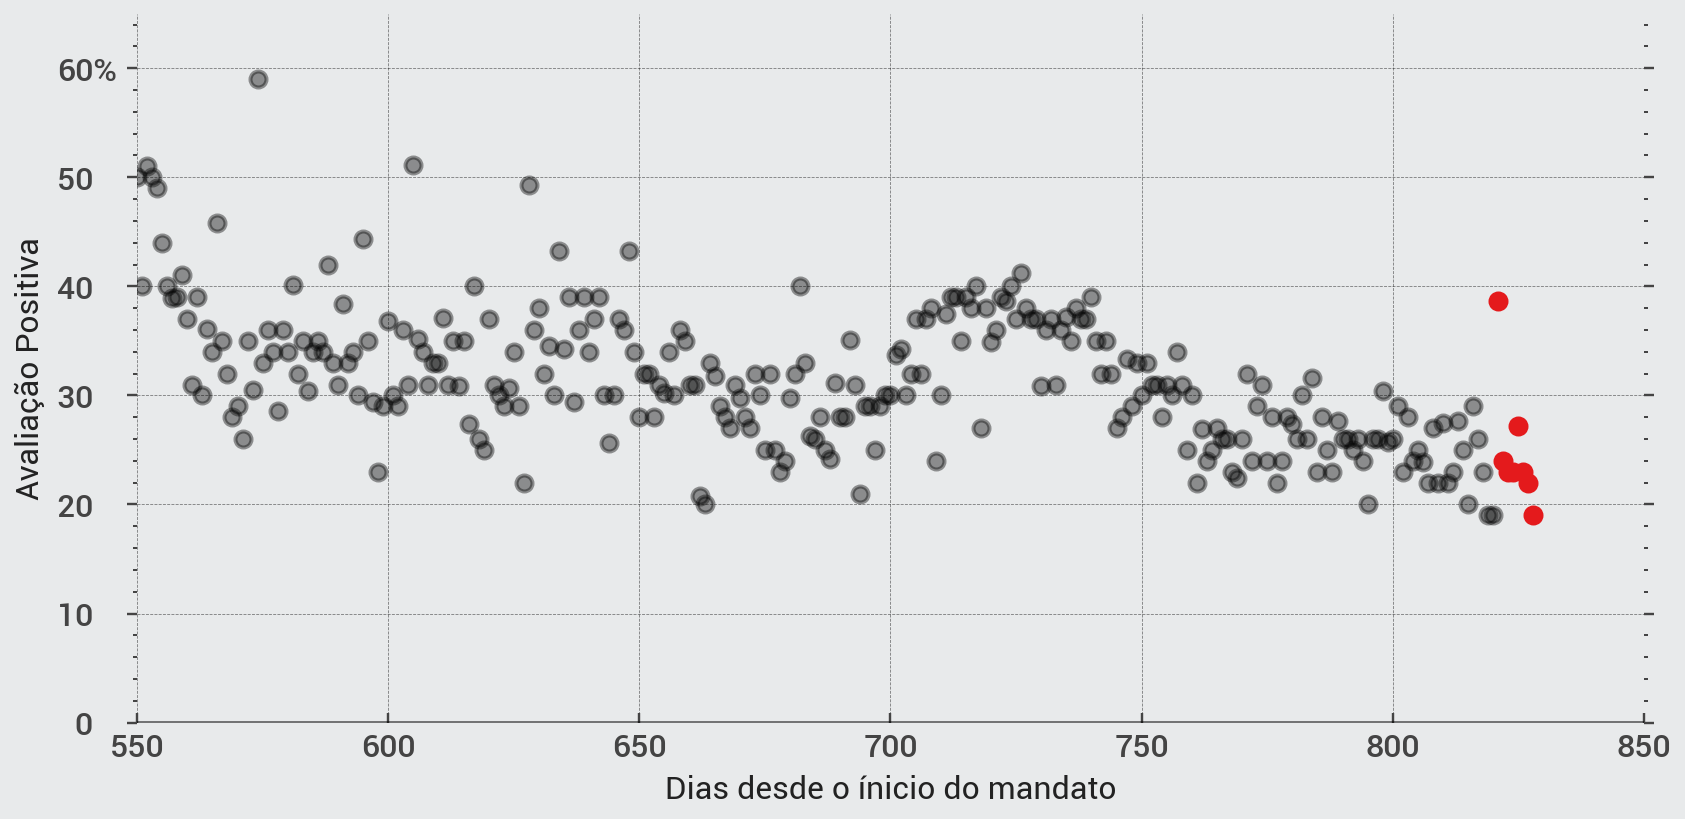

In [209]:
aprovacao = data.loc[data.presidente == "Jair Bolsonaro"]["positiva"].values
dias = data.loc[data.presidente == "Jair Bolsonaro"].index

with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dias[:-8], 100*aprovacao[:-8], "o", color="k", alpha=0.4)
    ax.plot(dias[-8:], 100*aprovacao[-8:], "o")
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60%'])
    ax.set_ylim(0, 65)
    ax.set_ylabel(f"Avaliação Positiva")
    ax.set_xlabel("Dias desde o ínicio do mandato")
    # Generate a bolded horizontal line at y = 0
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .5)
    fig.tight_layout();
    
    plt.savefig('../figures/bolsonaro_ruido_avaliacao_positiva.png', dpi=300)
# The signature bar
# ax.text(x = 725, y = -7, s = ' ©JOTA Labs', fontsize = 14, color = '#7F7F7F', backgroundcolor = '#f0f0f0');
# Adding a title and a subtitle
# ax.text(x = 400, y = 70, s = "Pesquisas podem apresentar superdispersão - mesmo quando coletadas no mesmo período", fontsize = 22, weight = 'bold', alpha = .75)

# Modos 

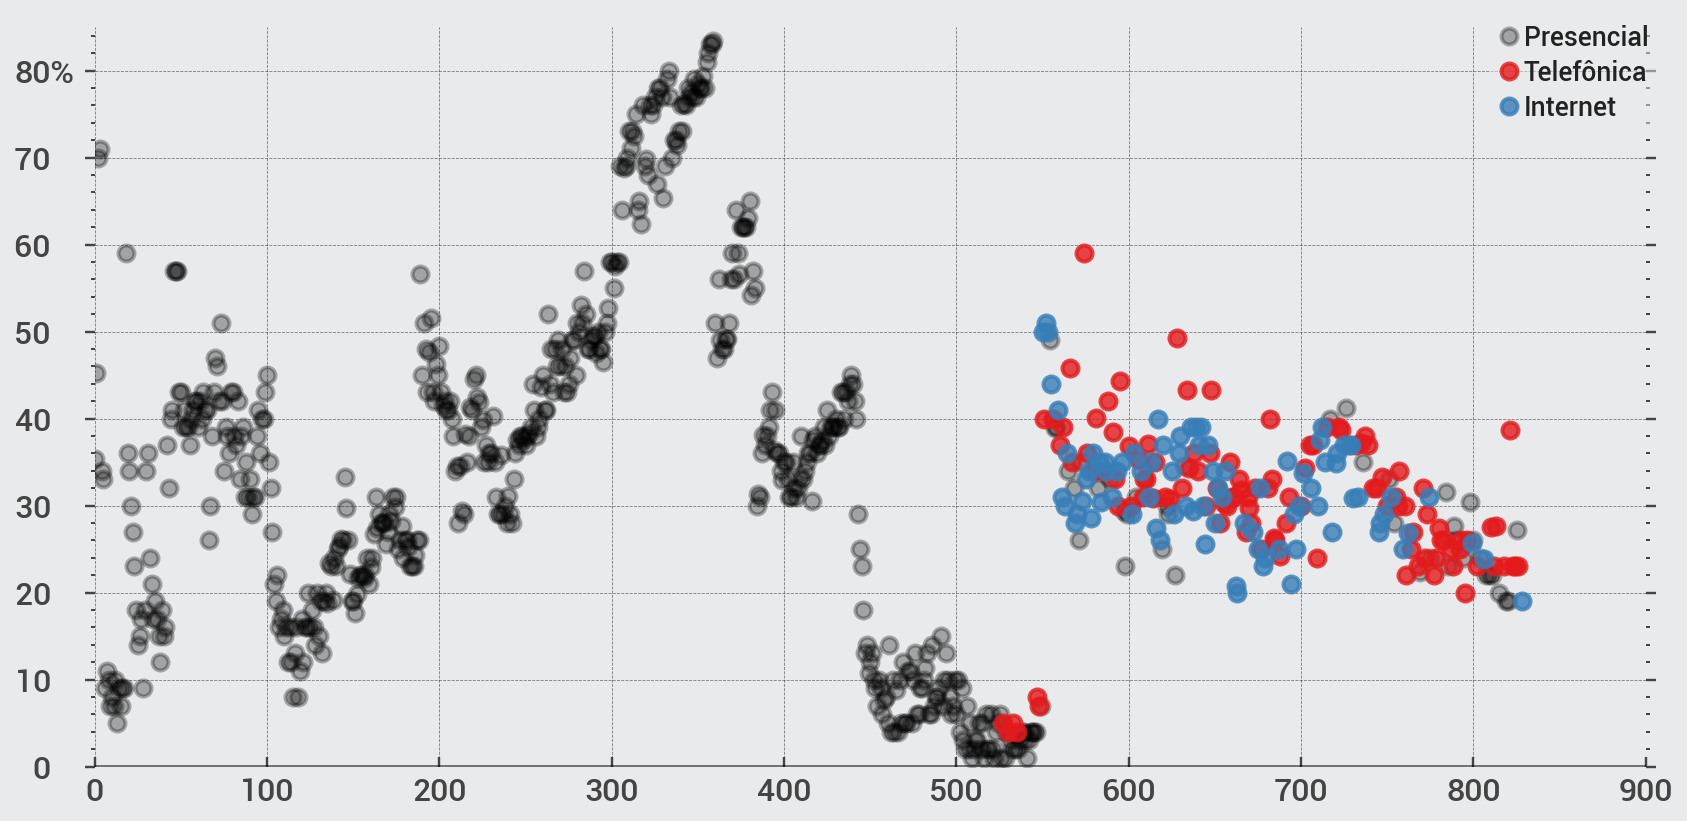

In [210]:
# dados
newterm_dates = data.reset_index().groupby("presidente").first()["data_fim"].values

precencial = data[data["modo"] == "Presencial"]
dates_precencial = precencial.index

telefone = data[(data["modo"] == "CATI") | (data["modo"] == "IRV")]
dates_telefone = telefone.index

online = data[data["modo"] == "Internet"]
dates_online = online.index


# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_precencial, 100*precencial["positiva"].values, "o", label="Presencial", color="k", alpha=0.3)
    ax.plot(dates_telefone, 100*telefone["positiva"].values, "o", alpha=0.8, label="Telefônica")
    ax.plot(dates_online, 100*online["positiva"].values, "o", alpha=0.8, label="Internet")
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60   ', '70   ', '80%'])
    ax.set_ylim(0, 85)
    ax.legend()
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .5)
    fig.tight_layout();
# ax.set_ylabel("Índice positivo de avaliação")
# ax.set_title("Pesquisas de avaliação de governo")



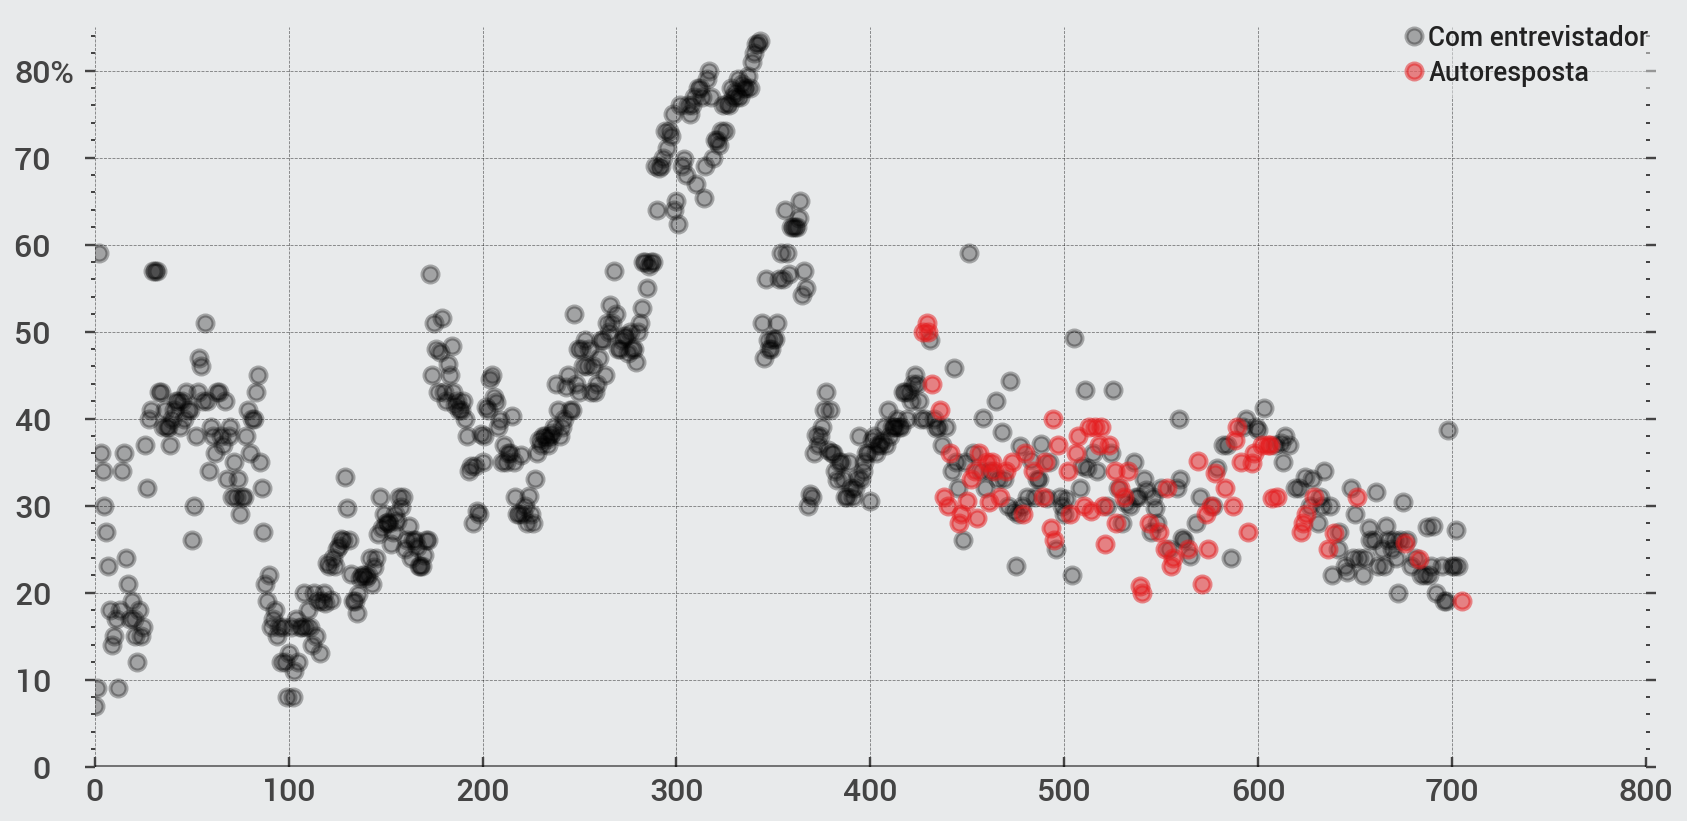

In [13]:
# dados
entrevistador = data[(data["modo"] == "CATI") | (data["modo"] == "Presencial")]
dates_entrevistador = entrevistador.index

autoresposta =  data[(data["modo"] == "IRV") | (data["modo"] == "Internet")] 
dates_autoresposta = online.index

# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_entrevistador, 100*entrevistador["positiva"].values, "o", label="Com entrevistador", color="k", alpha=0.3)
    ax.plot(dates_autoresposta, 100*autoresposta["positiva"].values, "o", alpha=0.5, label="Autoresposta")
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60   ', '70   ', '80%'])
    ax.set_ylim(0, 85)
    ax.legend()
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .5)
    fig.tight_layout();
# ax.set_ylabel("Índice positivo de avaliação")
# ax.set_title("Pesquisas de avaliação de governo")

## Modelo

Vamos preparar os dados e estrutura da informação para o modelo escolhido:

In [211]:
empresa_por_metodo_id, empresa_por_metodo = data.set_index(
    ["empresa", "modo"]
).index.factorize(sort=True)

mes_id = np.hstack(
    [
        pd.Categorical(
            data[data.presidente == presidente].data_fim.dt.to_period("M")
        ).codes
        for presidente in data.presidente.unique()
    ]
)

meses = np.arange(max(mes_id) + 1)

data["mes_id"] = mes_id

presidente_id, presidentes = data["presidente"].factorize(sort=False)

COORDS = {
    "empresa_por_metodo": empresa_por_metodo,
    "mes": meses,
    "mes_menos_origem": meses[1:],
    "presidente": presidentes,
    "observacao": data.set_index(["empresa", "data_fim"]).index,
}

In [15]:
print(COORDS)

{'empresa_por_metodo': MultiIndex([(             'Atlas',   'Internet'),
            (        'Brasmarket',       'CATI'),
            (               'CNT', 'Presencial'),
            (         'Datafolha',       'CATI'),
            (         'Datafolha', 'Presencial'),
            (            'Futura',       'CATI'),
            (             'IDEIA',       'CATI'),
            (             'IDEIA',   'Internet'),
            (         'INCT/IDDC',       'CATI'),
            (         'INCT/IDDC', 'Presencial'),
            (             'Ibope', 'Presencial'),
            (             'Ibpad',       'CATI'),
            (     'Instituto FSB',       'CATI'),
            ('Instituto Methodus',       'CATI'),
            (              'Ipec', 'Presencial'),
            (            'Ipespe',       'CATI'),
            (               'MDA',       'CATI'),
            (               'MDA', 'Presencial'),
            (         'Offerwise',   'Internet'),
            (             '

Em seguida vamos definir a distribuição `ZeroSumNormal` que vamos usar para a versão final do modelo.
Qual é a racionalidade aqui? Vamos imaginar que X e Y são variáveis aleatórias e que são normalmente distribuídas (e portanto conjuntamente), então a soma dessas duas quantidades também serão distribuições normais.

Além disso, imagine que X, Y, W, Z tenham os seguintes desvios (-0.5, +1.2, +0.1, -0.8). Todos os elementos somam zero ou muito próximo disso e cada elemento em particular é muito pequeno, menor que 2% ou 3% que é a margem de erro geralmente estimada pelas empresas de pesquisa.


In [298]:
# https://en.wikipedia.org/wiki/Truncation_(statistics)
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
    ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncado_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncado_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncado_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_pollster(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_pollster(N: int) -> np.ndarray:
    """
    Build a polling house transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

E finalmente o modelo escolhido:

In [299]:
with pm.Model(coords=COORDS) as hierarchical_monthly_popularity:

    baseline = pm.Normal("baseline")
    efeito_presidente = ZeroSumNormal("efeito_presidente", sigma=0.15, dims="presidente")
    efeito_empresa = ZeroSumNormal("efeito_empresa", sigma=0.10, dims="empresa_por_metodo")
    efeito_mensal = ZeroSumNormal("efeito_mensal", sigma=0.10, dims="mes")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_inicial = aet.zeros(shape=(len(COORDS["presidente"]), 1))
    rw_variacoes = pm.Normal(
        "rw_choques",
        dims=("presidente", "mes_menos_origem"),
    )
    rw_bruto = aet.cumsum(aet.concatenate([rw_inicial, rw_variacoes], axis=-1), axis=-1)
    sd = pm.HalfNormal("contracoes_pop", 0.2)
    
    efeito_mes_presidente = pm.Deterministic(
        "efeito_mes_presidente", rw_bruto * sd, dims=("presidente", "mes")
    )

    popularidade = pm.math.invlogit(
        baseline
        + efeito_presidente[presidente_id]
        + efeito_mensal[mes_id]
        + efeito_mes_presidente[presidente_id, mes_id]
        + efeito_empresa[empresa_por_metodo_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_dispersao", 1.0) + 10.0

    polls = pm.BetaBinomial(
        "likelihood",
        alpha=popularidade * theta,
        beta=(1.0 - popularidade) * theta,
        n=data["amostra"],
        observed=data["positiva_int"],
        dims="observacao",
    )

### Execução do modelo

In [300]:
with hierarchical_monthly_popularity:
    aprovacao_trace = pm.sample(tune=2000, draws=2000, chains=4, return_inferencedata=True, target_accept=0.95)
    
# https://colcarroll.github.io/ppl-api/    
# https://colindcarroll.com/2019/11/29/highlights-of-pymc3-v3.8/
# NUTS is distinguished from Hamiltonian Monte Carlo (HMC) in that it can explore posterior distributions of different scales using a dynamic path length. HMC, by contrast, will have a fixed path length. Longer paths will be slower, but produce “more independent” samples. NUTS uses a heuristic to balances these desires: when the trajectory “makes a U-turn”, we stop integrating.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_dispersao, contracoes_pop, rw_choques, efeito_mensal_truncado_, efeito_empresa_truncado_, efeito_presidente_truncado_, baseline]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 725 seconds.


0, dim: observacao, 829 =? 829


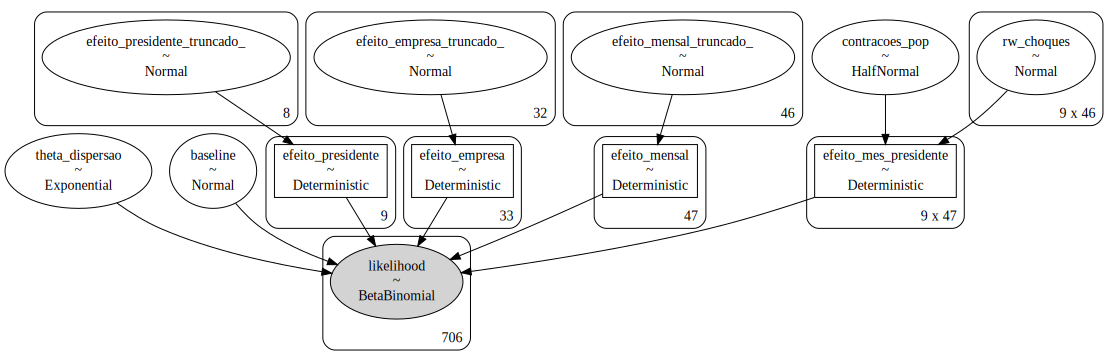

In [63]:
# Salva uma representação do modelo em png
# conda install python-graphviz 
# conda install python-graphviz -n polls
ph = pm.model_to_graphviz(hierarchical_monthly_popularity)
ph.render("hierarchical_monthly_popularity", format="png")

pm.model_to_graphviz(hierarchical_monthly_popularity)

Vamos olhar os dados das simulações para ver se são plausíveis ou se precisam de algum ajuste nos parâmetros:

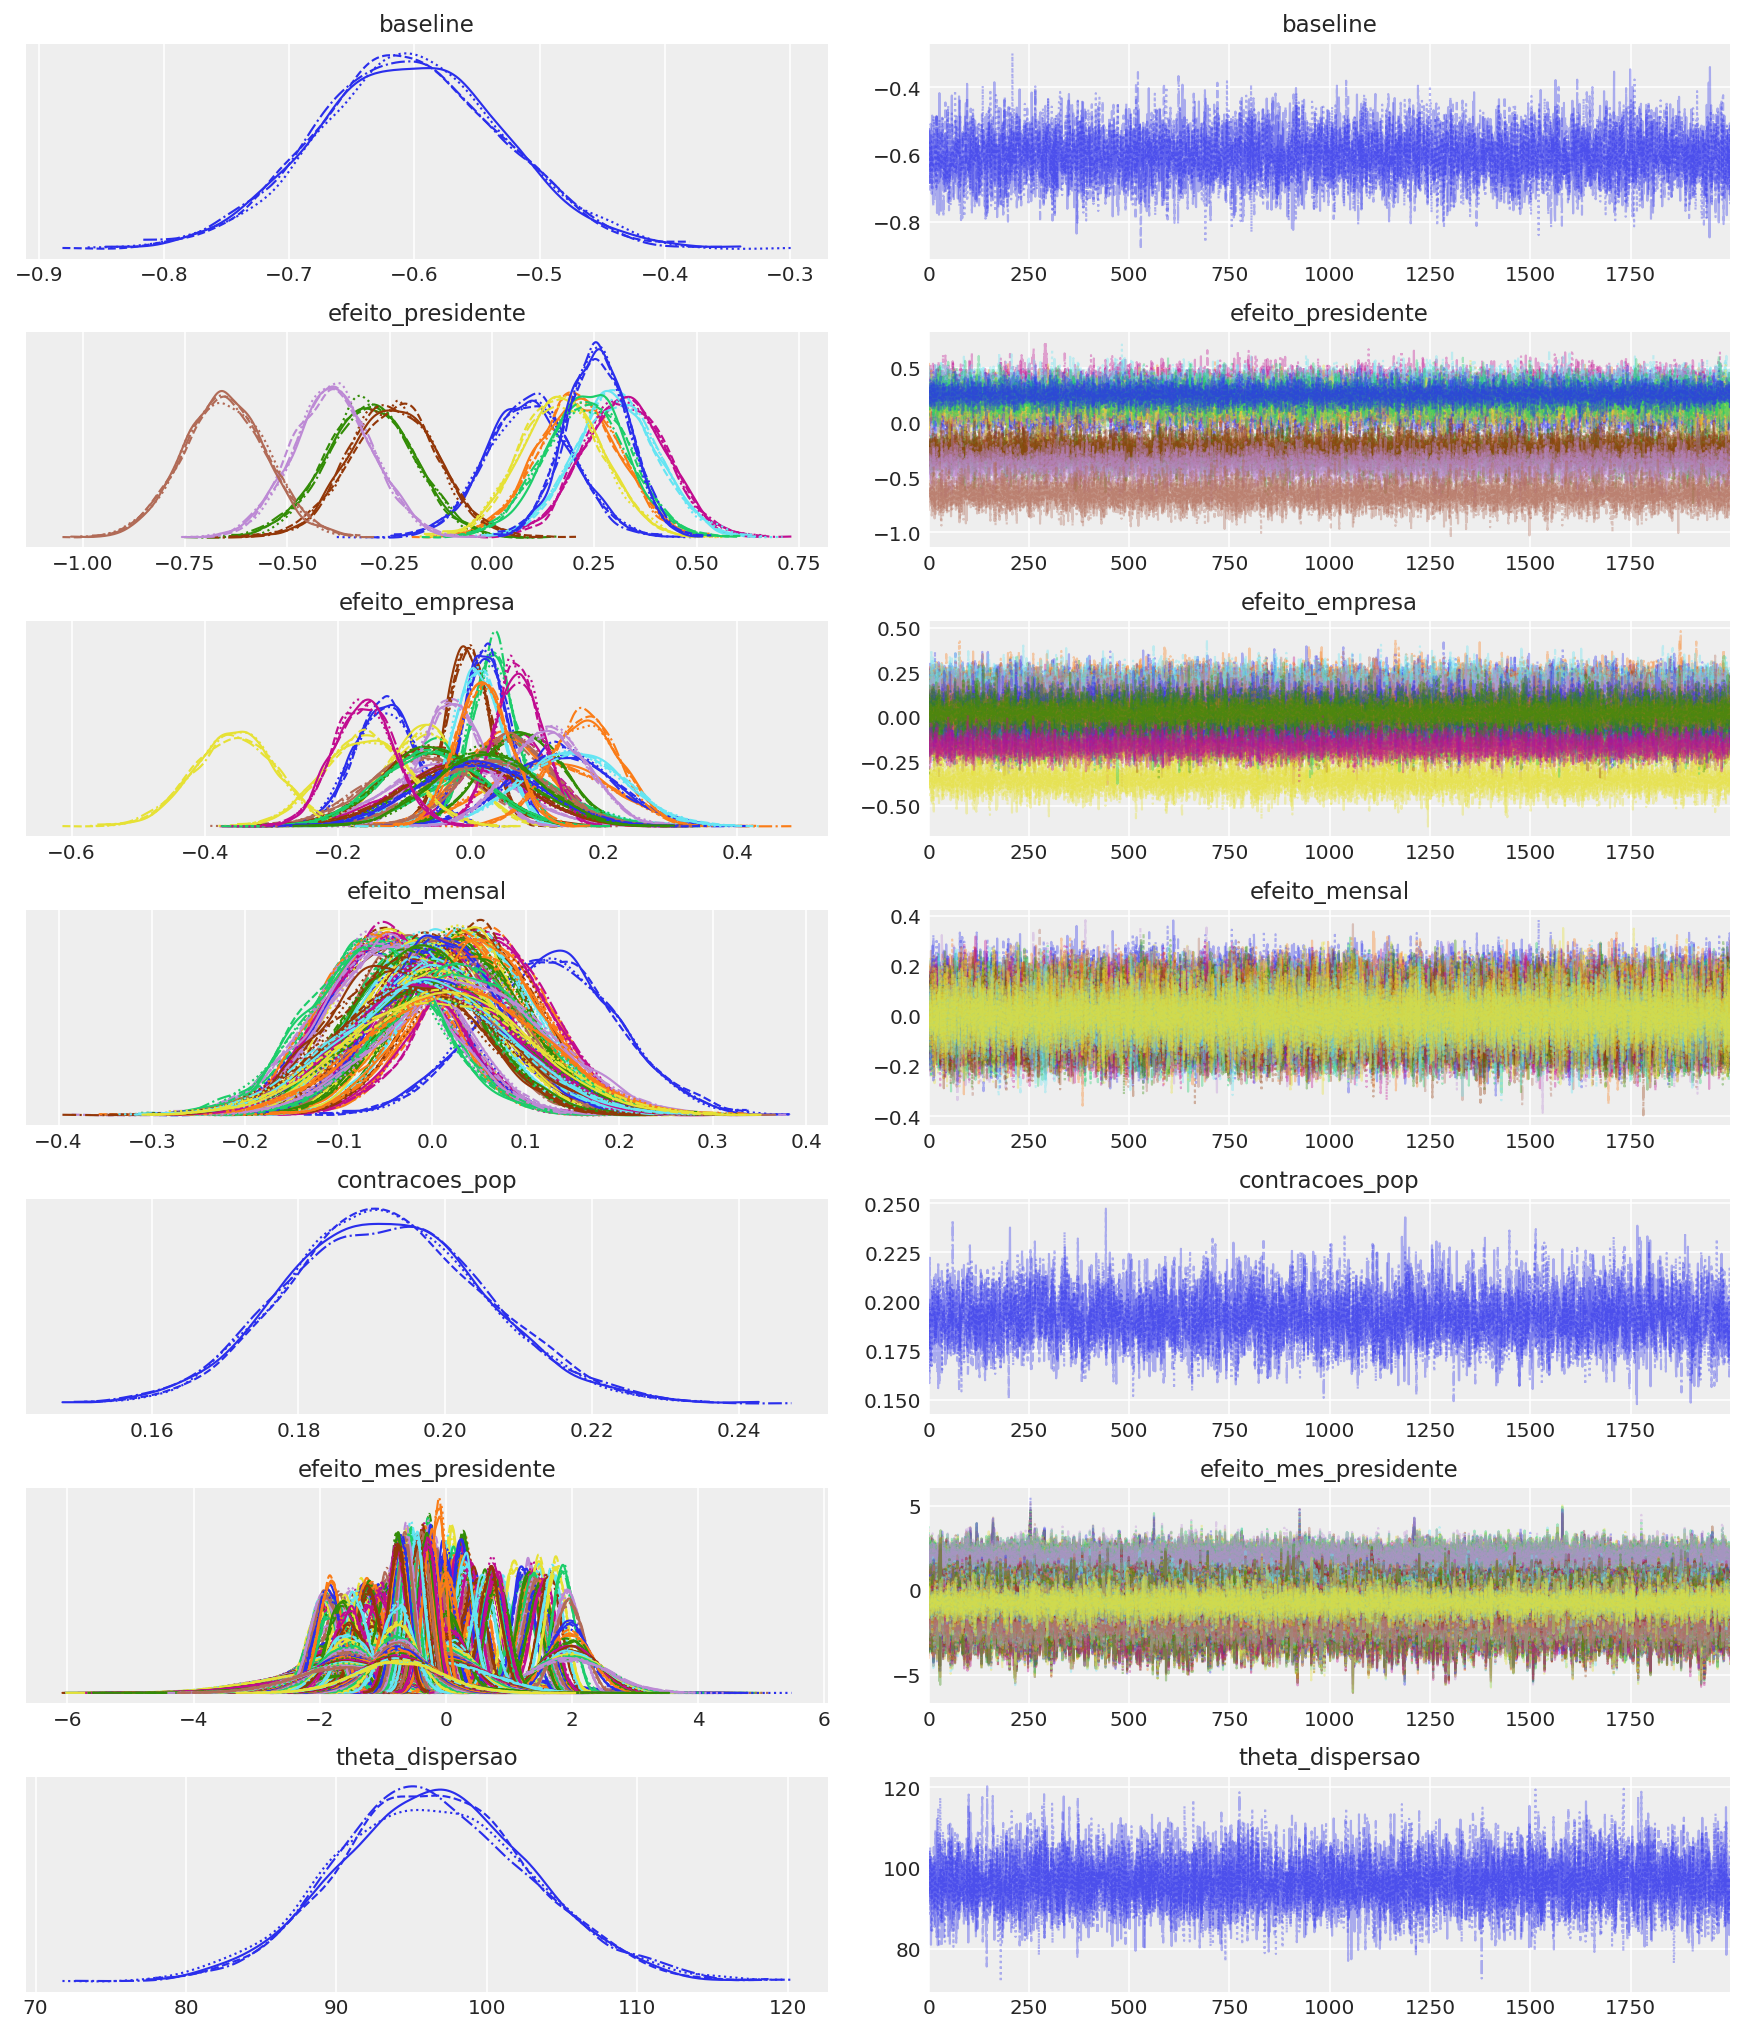

In [301]:
traces = az.plot_trace(
    aprovacao_trace,
    var_names=["~truncado", "~rw_choques"],
    filter_vars="regex",
    compact=True,
);

fig = traces.ravel()[0].figure
fig.savefig("popularidade_positiva_trace")

Veja o número de amostras efetivas e $\hat{R}$

In [216]:
df_trace = az.summary(
    aprovacao_trace,
    round_to=2,
    var_names=["~truncado", "~rw_choques"],
    filter_vars="regex",
)

df_trace.to_csv('df_trace_positiva.csv', sep=";", index=False)


az.summary(
    aprovacao_trace,
    round_to=2,
    var_names=["~truncado", "~rw_choques"],
    filter_vars="regex",
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  \
baseline                      -0.66  0.09   -0.83    -0.49       0.00   
efeito_presidente[0]           0.10  0.10   -0.10     0.29       0.00   
efeito_presidente[1]           0.22  0.10    0.02     0.41       0.00   
efeito_presidente[2]          -0.29  0.10   -0.49    -0.10       0.00   
efeito_presidente[3]           0.31  0.10    0.13     0.52       0.00   
...                             ...   ...     ...      ...        ...   
efeito_mes_presidente[10,43]  -0.69  0.59   -1.80     0.42       0.00   
efeito_mes_presidente[10,44]  -0.69  0.62   -1.86     0.45       0.00   
efeito_mes_presidente[10,45]  -0.69  0.65   -1.93     0.52       0.00   
efeito_mes_presidente[10,46]  -0.69  0.67   -1.98     0.55       0.00   
theta_dispersao               97.96  6.67   85.96   110.57       0.07   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
baseline                         0.00   5019.76   5623.56    1.0  
efeito_presidente[0]             0.00  14417.52   6263.22    1.0  
efeito_presidente[1]             0.00  15589.05   6349.16    1.0  
efeito_presidente[2]             0.00  16141.98   6295.26    1.0  
efeito_presidente[3]             0.00  14615.49   6241.23    1.0  
...                               ...       ...       ...    ...  
efeito_mes_presidente[10,43]     0.00  18965.77   5448.08    1.0  
efeito_mes_presidente[10,44]     0.00  19647.89   5530.91    1.0  
efeito_mes_presidente[10,45]     0.01  20313.89   5558.15    1.0  
efeito_mes_presidente[10,46]     0.01  20704.23   5798.45    1.0  
theta_dispersao                  0.05   9900.15   6656.89    1.0  

[612 rows x 9 columns]

## Estimativas a partir da Posterior
Vamos analisar os viéses calculados. Pra mim parecem bastante razoáveis:


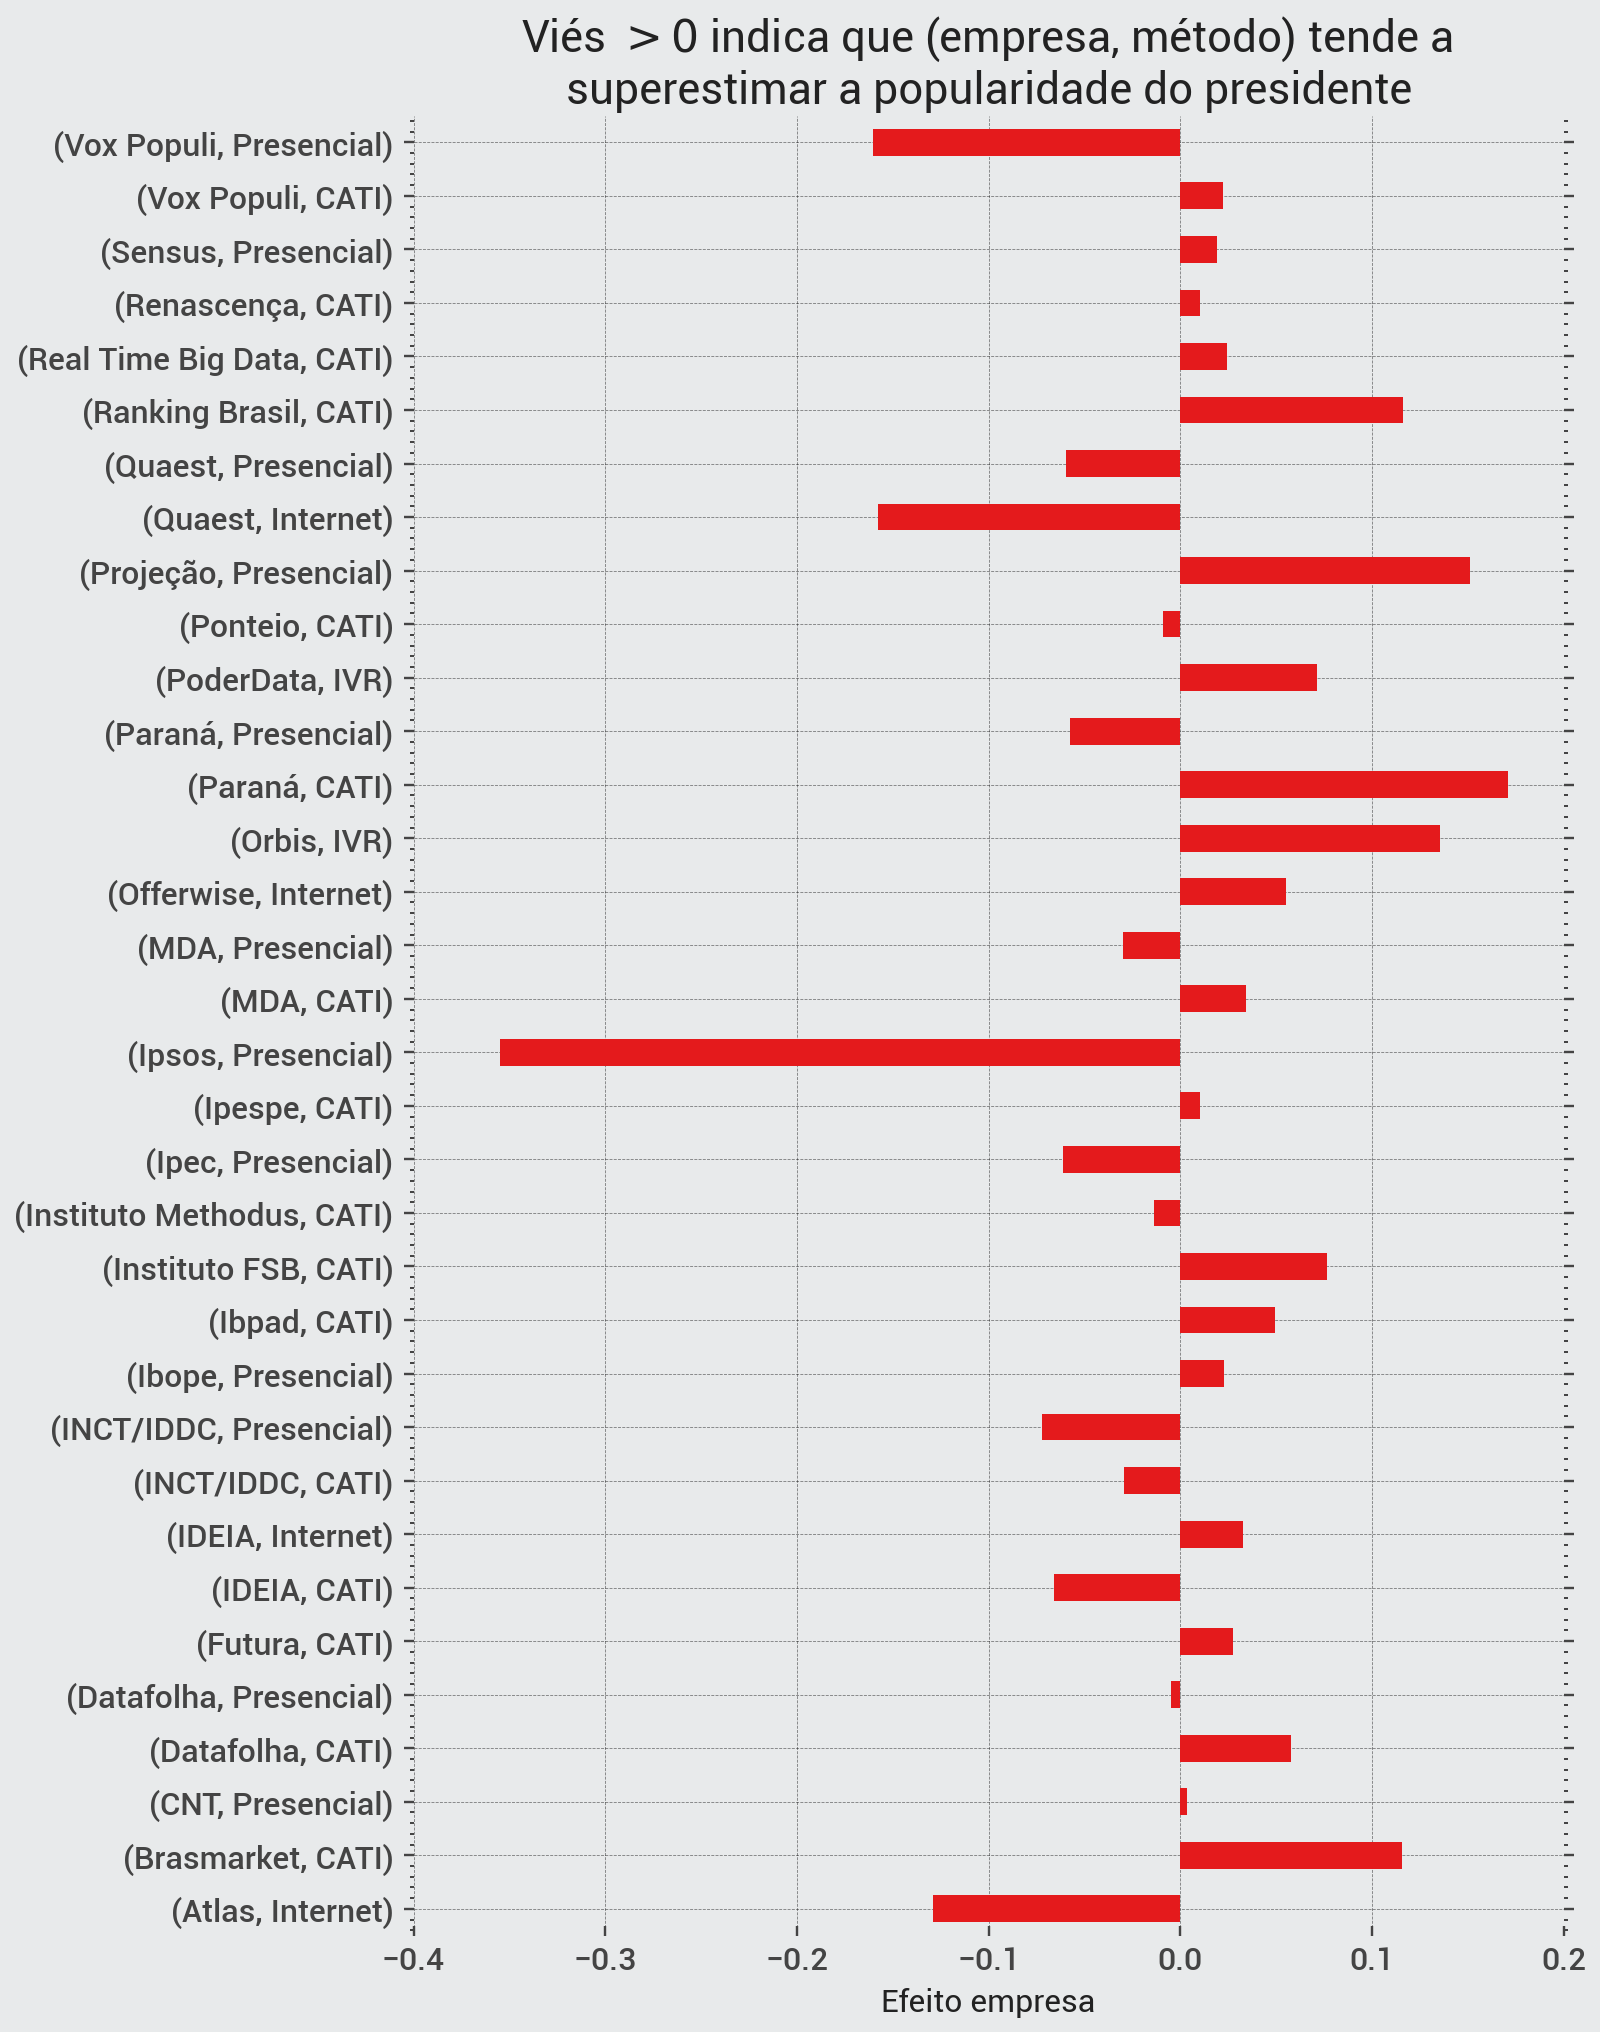

In [334]:
media_efeito_empresa = (
    aprovacao_trace.posterior["efeito_empresa"].mean(("chain", "draw")).to_dataframe()
)



with plt.style.context(['jotaviz']):
    ax = media_efeito_empresa.plot.barh(figsize=(11, 14), align='center', legend=None)
    ax.set_xlabel("Efeito empresa")
    ax.set_ylabel(None)
    ax.set_title("Viés $>0$ indica que (empresa, método) tende a \nsuperestimar a popularidade do presidente", fontsize=22);
    
    #plt.savefig('../figures/vies_empresas_metodo.png', dpi=300)
    ax.figure.savefig('../figures/vies_empresas_metodo.png')


In [ ]:
ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60   ', '70   ', '80%'])
    ax.set_ylim(0, 85)
    ax.legend()
    ax.set_ylabel("Avaliação positiva")
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .5)
    ax.text(x = pd.to_datetime("2019-01-01"), y = -8, s = ' ©JOTA Labs', fontsize = 14, color = '#7F7F7F');
    ax.set_xlim([datetime.date(1985, 1, 1), datetime.date(2021, 12, 31)])
    fig.tight_layout()
    
    # for date in newterm_dates:
    #    ax.axvline(date, color="red", alpha=0.2, linestyle="--")

    plt.savefig('../figures/observado_predito_positiva.png', dpi=300)

In [220]:

data = data.merge(
    data.groupby(["ano", "mes"])["positiva"].mean().reset_index(),
    on=["ano", "mes"],
    suffixes=["", "_mean"],
)


obs_media = data.groupby(["presidente", "mes_id"]).last()["positiva_mean"].unstack().T

# display(HTML(obs_media.to_html()))

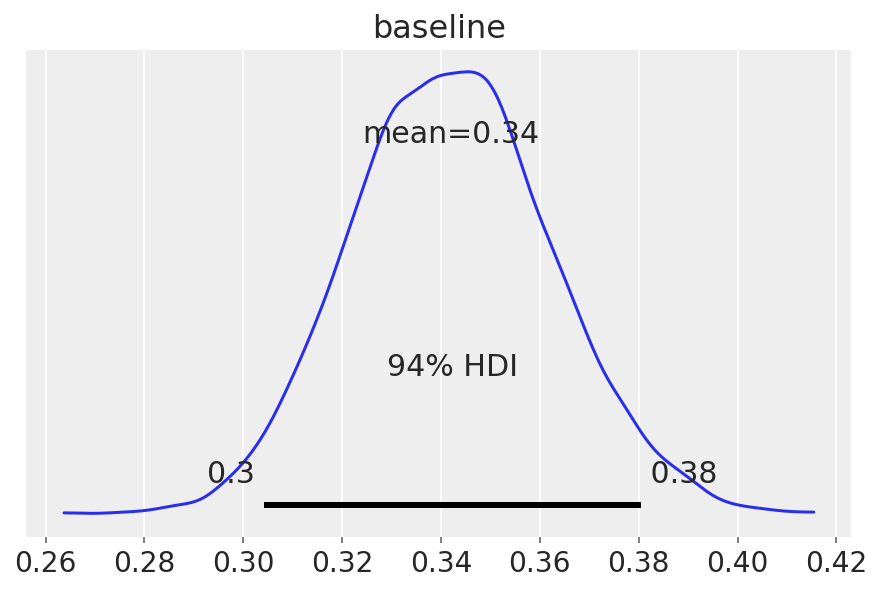

In [221]:
az.plot_posterior(logistic(aprovacao_trace.posterior["baseline"]));

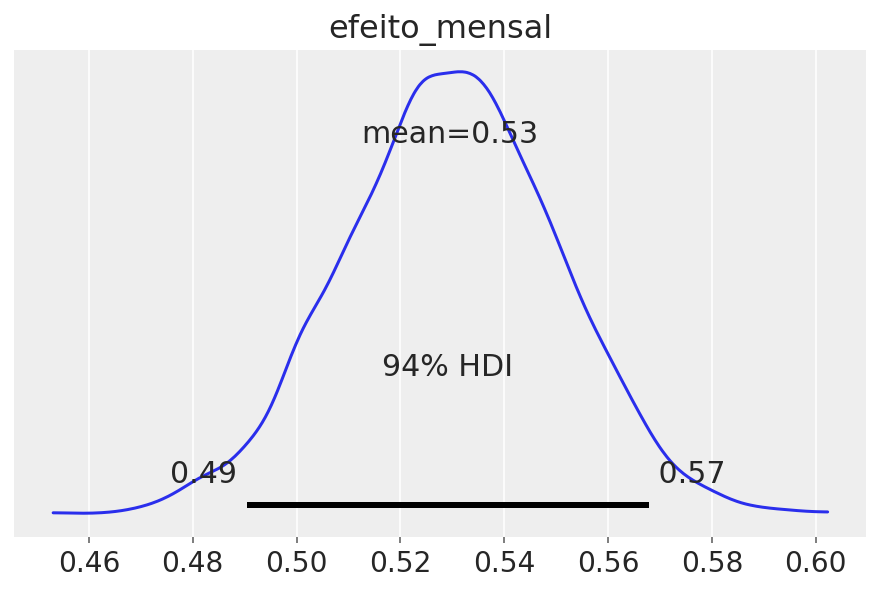

In [222]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mensal"].sel(mes=1)));

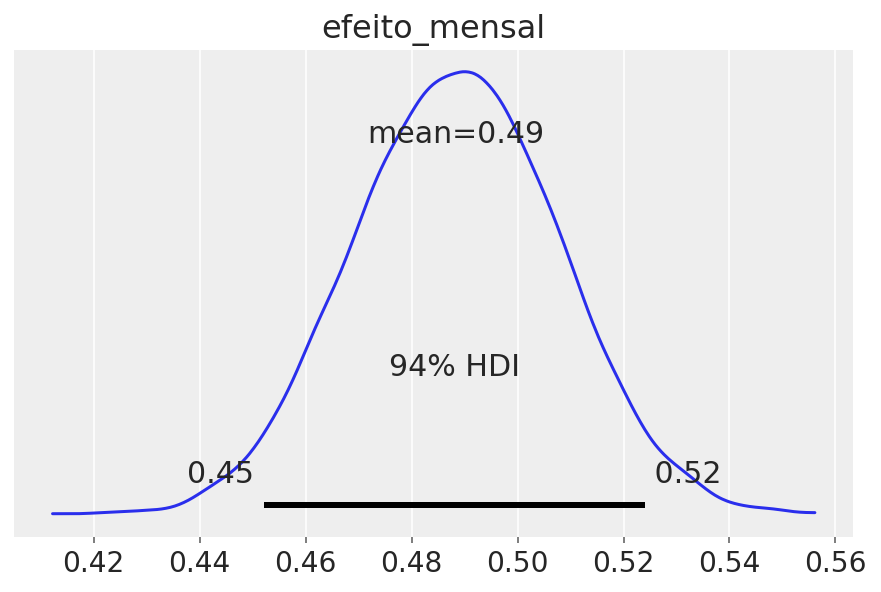

In [223]:
az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mensal"].sel(mes=4)));

In [29]:
# az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mes_presidente"].sel(mes=1)));

In [30]:
# az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_mes_presidente"].sel(mes=32)));

In [31]:

# az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_empresa"].sel(empresa_por_metodo_level_1="Internet")));

In [32]:
# az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_empresa"].sel(empresa_por_metodo_level_1="CATI")));

In [33]:
# az.plot_posterior(logistic(aprovacao_trace.posterior["efeito_empresa"].sel(empresa_por_metodo_level_1="Presencial")));

In [34]:
# az.plot_posterior(logistic(aprovacao_trace.posterior["rw_choques"]));

## Vamos ver as imagens 


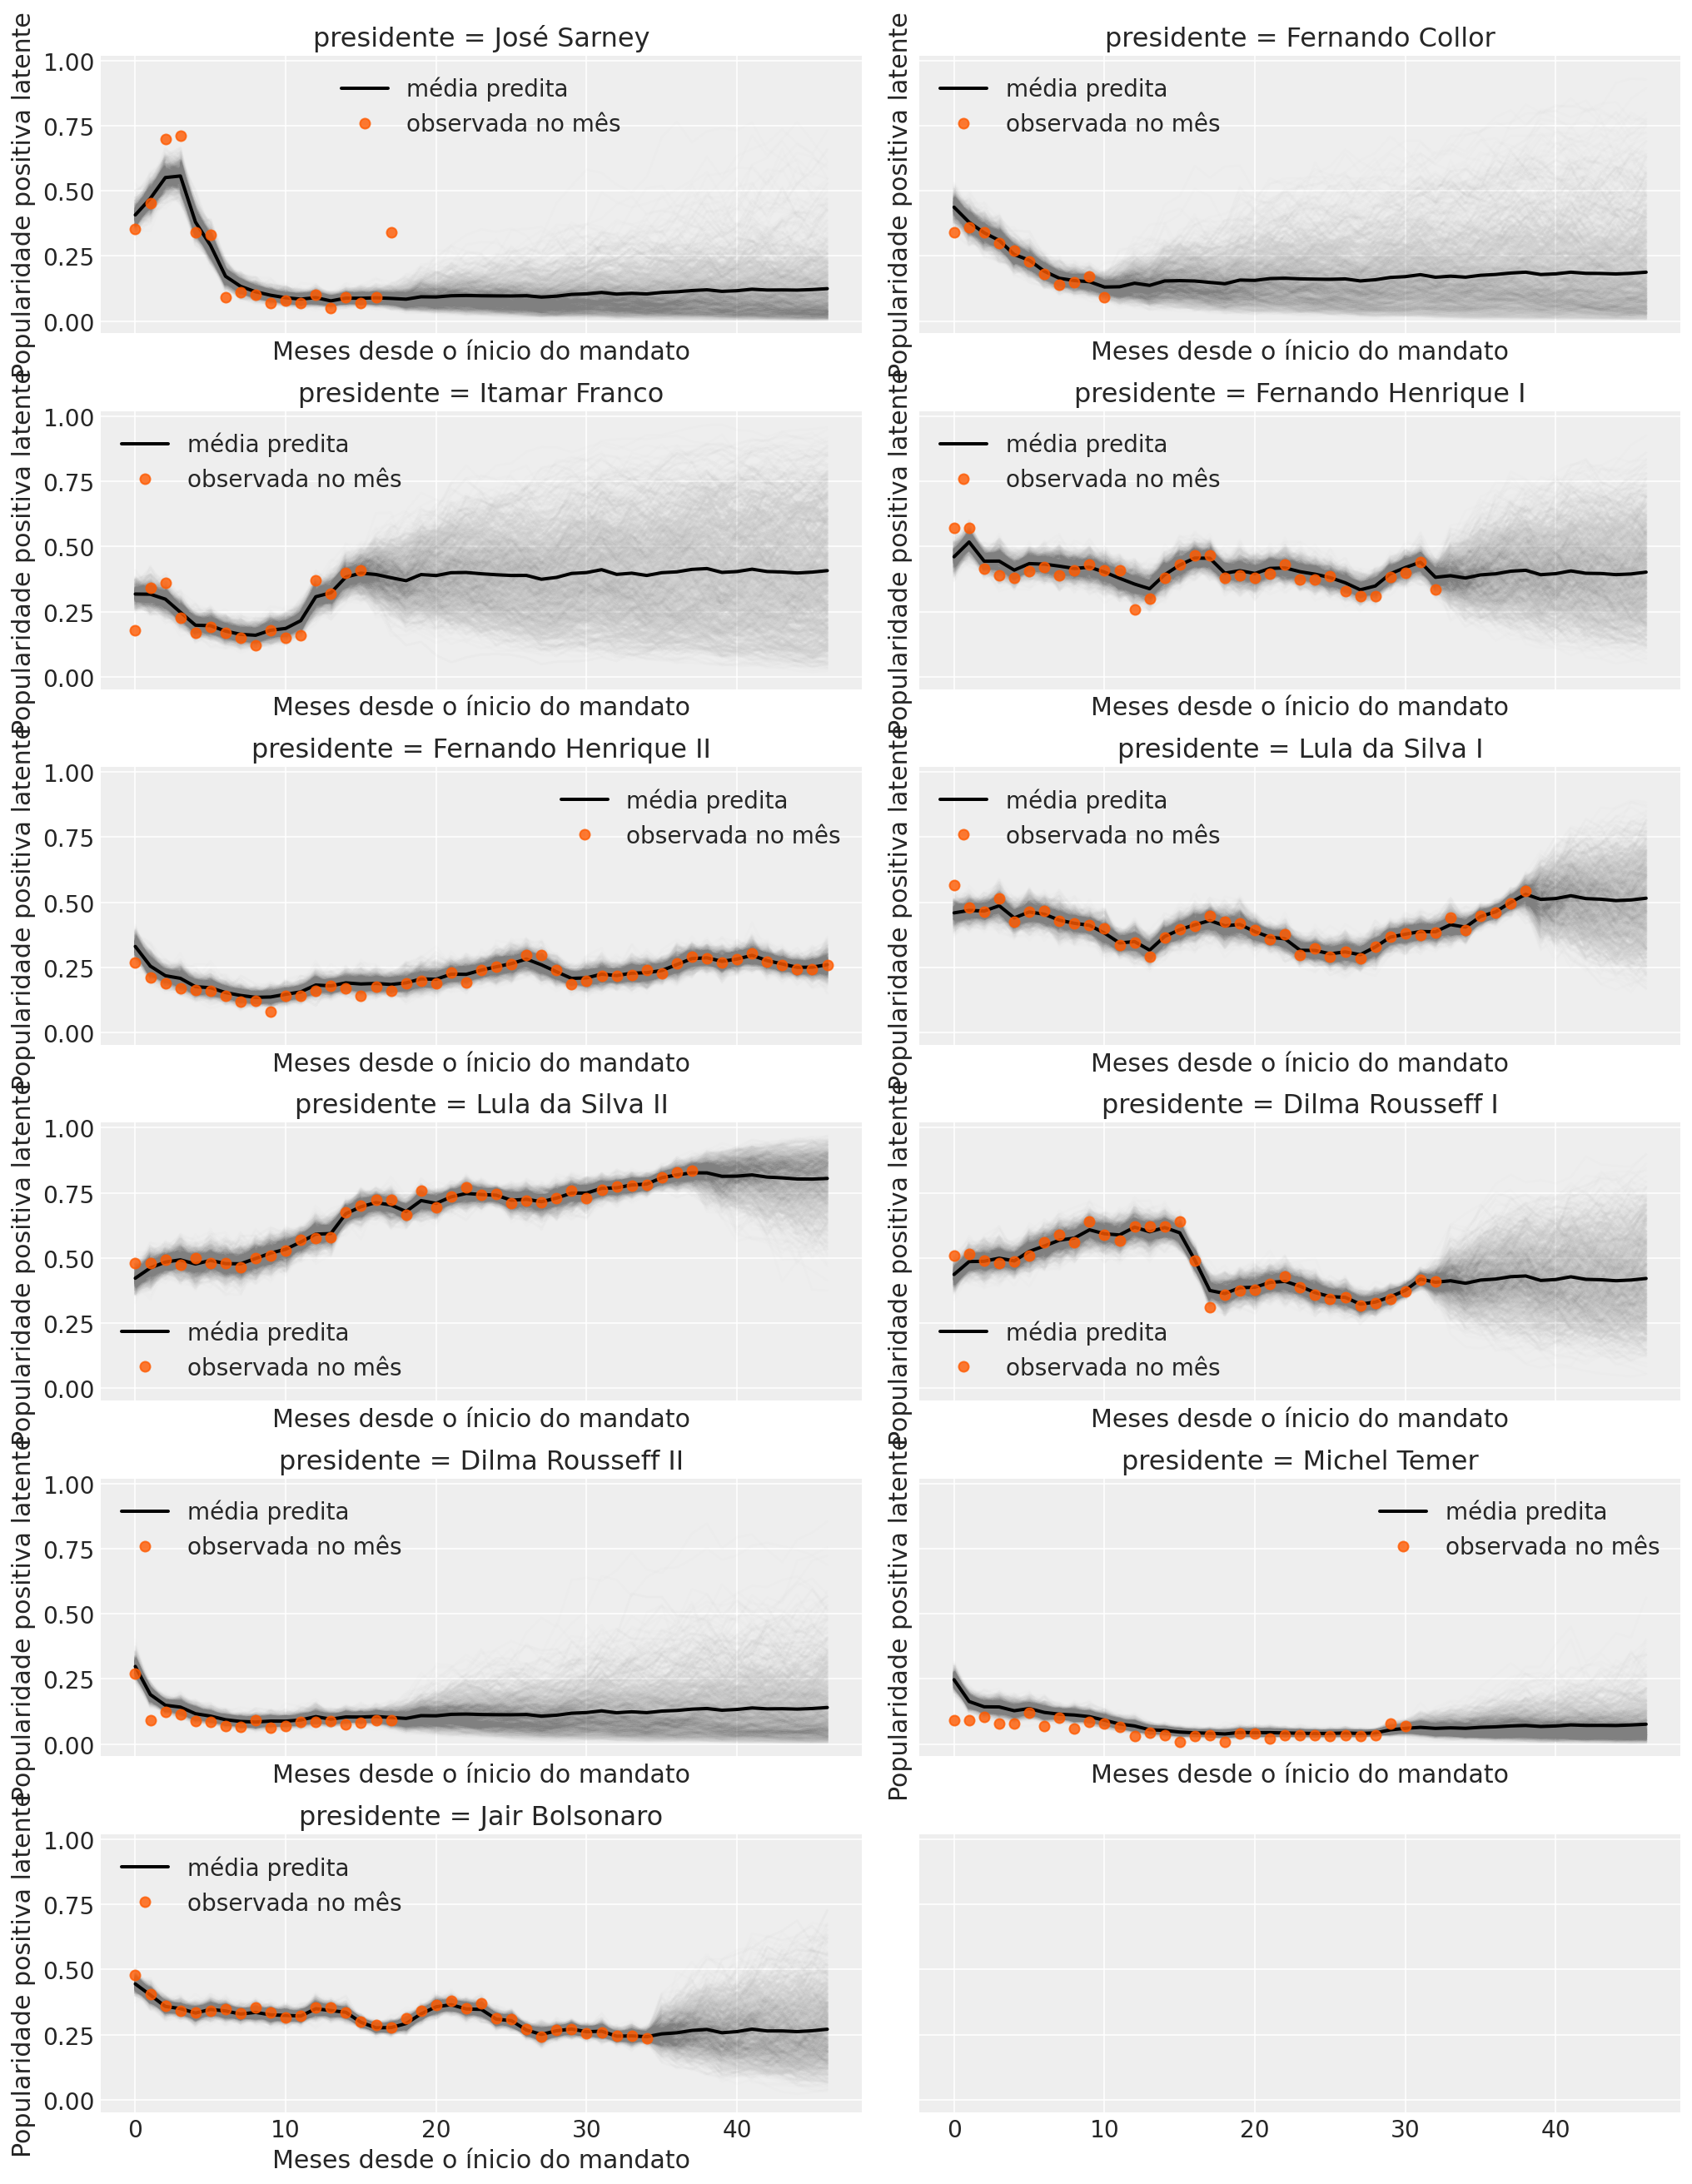

In [277]:

fig, axes = plt.subplots(6, 2, figsize=(14, 18), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), aprovacao_trace.posterior.coords["presidente"]):
    posterior = aprovacao_trace.posterior.sel(presidente=p)
    aprovacao_posterior = logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        posterior.coords["mes"],
        aprovacao_posterior.isel(
            sample=np.random.choice(aprovacao_posterior.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    aprovacao_posterior.mean("sample").plot(ax=ax, color="black", lw=2, label="média predita")
    
    # plot monthly raw polls
    ax.plot(
        obs_media.index,
        obs_media[p.data],
        "o",
        color=cariations[0],
        alpha=0.8,
        label="observada no mês",
    )
    ax.set_xlabel("Meses desde o ínicio do mandato")
    ax.set_ylabel("Popularidade positiva latente")
    ax.legend()

## Inferência a partir da Distribuição Posterior

Vamos olhar as distribuições preditivas da posterior, só vamos considerar as estimativas quando o modelo convergir amostrar e convergir corretamente. 

In [227]:
with hierarchical_monthly_popularity:
    aprovacao_trace.extend(
        az.from_pymc3(
            posterior_predictive = pm.sample_posterior_predictive(aprovacao_trace),
        )
    )

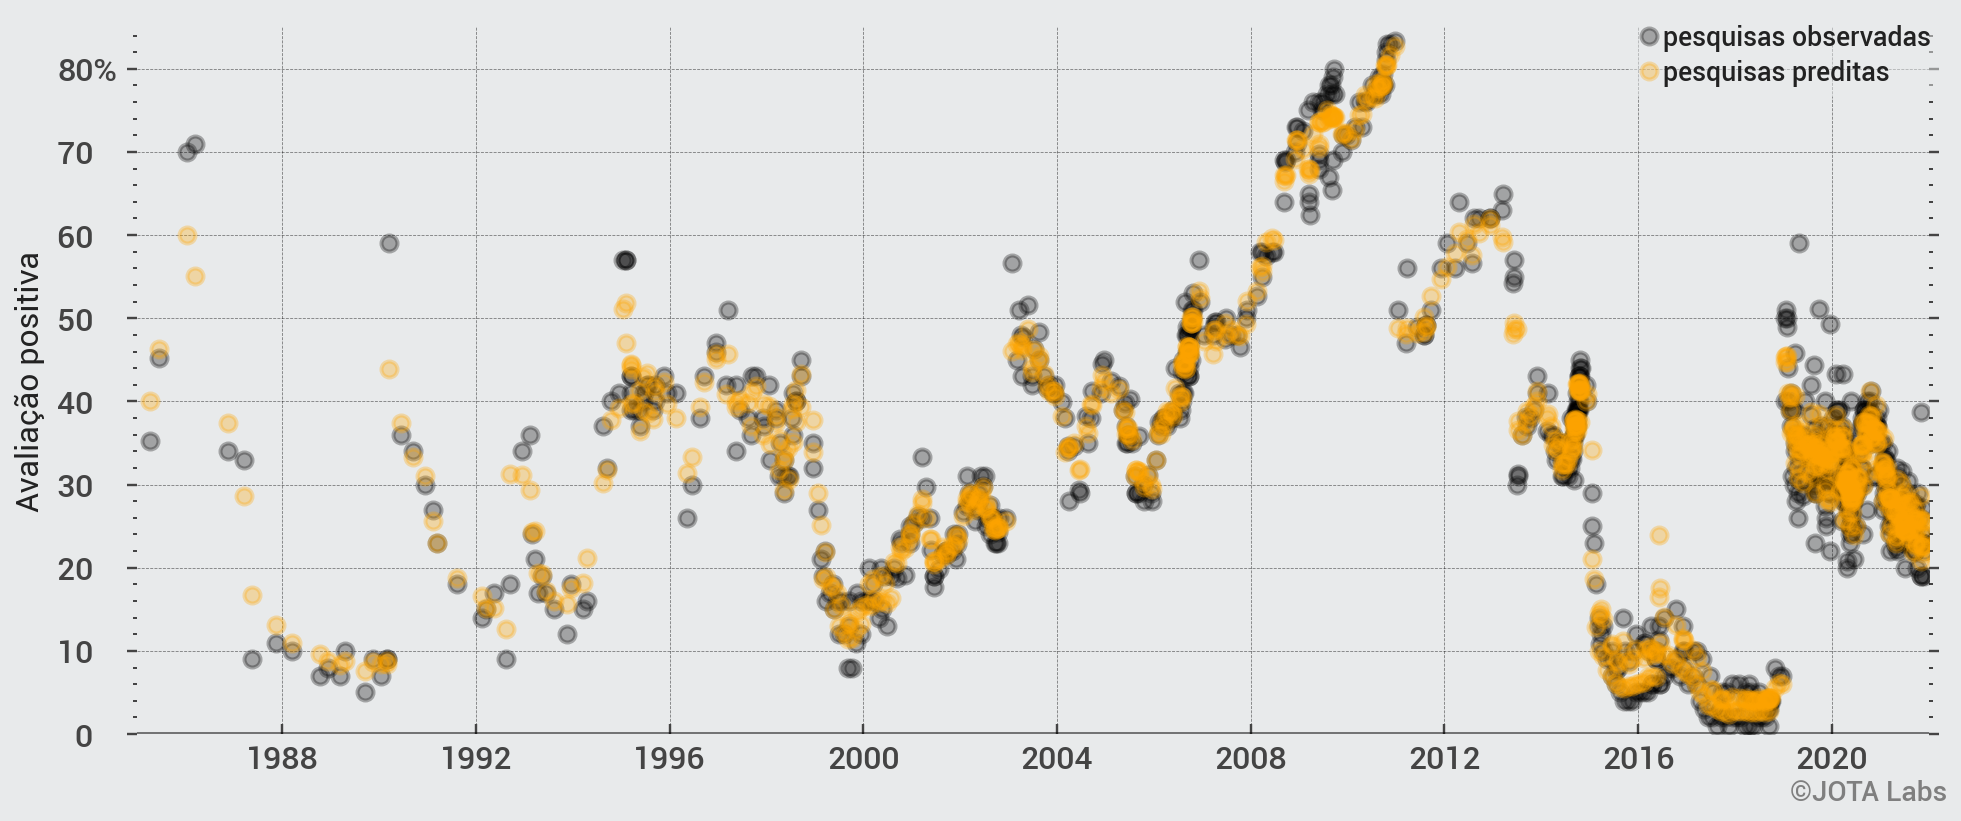

In [251]:
aprovacao_predita = (
    aprovacao_trace.posterior_predictive.mean(("chain", "draw"))["likelihood"] / data["amostra"]
)

    
dates = aprovacao_predita.data_fim
newterm_dates = data.groupby("presidente").first()["data_fim"].values



# Plot
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(dates, 100*data["positiva"].values, "o", label="pesquisas observadas", color="k", alpha=0.3)
    ax.plot(dates, 100*aprovacao_predita, "o", color="orange", alpha=0.3, label="pesquisas preditas")
    ax.set_yticklabels(labels = ['0   ', '10   ', '20   ', '30   ', '40   ', '50   ', '60   ', '70   ', '80%'])
    ax.set_ylim(0, 85)
    ax.legend()
    ax.set_ylabel("Avaliação positiva")
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .5)
    ax.text(x = pd.to_datetime("2019-01-01"), y = -8, s = ' ©JOTA Labs', fontsize = 14, color = '#7F7F7F');
    ax.set_xlim([datetime.date(1985, 1, 1), datetime.date(2021, 12, 31)])
    fig.tight_layout()
    
    # for date in newterm_dates:
    #    ax.axvline(date, color="red", alpha=0.2, linestyle="--")

    plt.savefig('../figures/observado_predito_positiva.png', dpi=300)

In [253]:
data['previsto'] = (aprovacao_trace.posterior_predictive.mean(("chain", "draw"))["likelihood"]) / data["amostra"]

# subset
observado_previsto = data[['data_fim', 'empresa', 'positiva','previsto']]

observado_previsto['positiva'] = (observado_previsto['positiva']*100).round(1)
observado_previsto['previsto'] = (observado_previsto['previsto']*100).round(1)
observado_previsto["diff"] = (observado_previsto['positiva'] - observado_previsto['previsto'])
# observado_previsto['serie'] = 'positiva'

observado_previsto = observado_previsto.rename(columns={'positiva': 'observado'})

observado_previsto.round(3).to_csv('positivo_observado_previsto.csv', sep=";", index=False)

observado_previsto

data_fim    empresa  observado  previsto  diff
0   1985-04-10  Datafolha       35.3      40.1  -4.8
1   1985-06-18  Datafolha       45.2      46.3  -1.1
2   1986-01-15   Projeção       70.0      60.0  10.0
3   1986-03-15  Datafolha       71.0      55.1  15.9
4   1986-11-21  Datafolha       34.0      37.4  -3.4
..         ...        ...        ...       ...   ...
824 2021-11-18    Ponteio       23.0      23.9  -0.9
825 2021-11-19     Paraná       27.2      22.5   4.7
826 2021-11-22      IDEIA       23.0      22.7   0.3
827 2021-11-24  PoderData       22.0      25.6  -3.6
828 2021-11-26      Atlas       19.0      21.8  -2.8

[829 rows x 5 columns]

In [254]:
def bias(y_true, y_pred):
    """
         Bias=\\frac{1}{N}\\sum_{i=1}^{N}(e_{i}-s_{i})
    """
    if len(y_true) == len(y_pred):
        obs, sim = np.array(y_true), np.array(y_pred)
        bias = np.nansum(obs - sim) / len(obs)
        return float(round(bias,2))
    else:
        return np.nan
    
    
def pbias(y_true, y_pred):
    """
    Procentual Bias
        .. math::
         PBias= 100 * \\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})}{\\sum_{i=1}^{N}(e_{i})}
    """
    if len(y_true) == len(y_pred):
        sim = np.array(y_pred)
        obs = np.array(y_true)
        pbias = 100 * (float(np.nansum(sim - obs))/float(np.nansum(obs)))
        return float(round(pbias,2))
    else:
        return np.nan


def nashsutcliffe(y_true, y_pred):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(y_true) == len(y_pred):
        s, e = np.array(y_pred), np.array(y_true)
        # s,e=simulation,evaluation
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return round(1 - (numerator / denominator),3)

    else:
        return np.nan

    
    
def mean_squared_error(y_true, y_pred):
    return round(np.sqrt(((y_pred - y_true) ** 2).mean()),2)


def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)



eficiencia = nashsutcliffe(observado_previsto['observado'],observado_previsto['previsto'])
print("Nash-Sutcliffe: " + str(eficiencia))

# Bias
bias_val = bias(observado_previsto['observado'],observado_previsto['previsto'])
print("BIAS: " + str(bias_val))

pbias_val = pbias(observado_previsto['observado'],observado_previsto['previsto'])
print("PBIAS: " + str(pbias_val))

# RMSE 
# Quão similar, na média, são os valores observados para os previstos?"
rmse_val = mean_squared_error(observado_previsto['observado'],observado_previsto['previsto'])
print("RMSE: " + str(rmse_val))

# MAPE
mape_val = mean_absolute_percentage_error(observado_previsto['observado'],observado_previsto['previsto'])
print("MAPE: " + str(mape_val))

Nash-Sutcliffe: 0.968
BIAS: -0.04
PBIAS: 0.13
RMSE: 3.11
MAPE: 10.1


Logo, para o modelo atual, o valor para MAPE é 6,5%. Ou seja, indica que a média da diferença absoluta entre o previsto e o valor observado é 6,5%.

In [255]:
observado_previsto["diff"] = (observado_previsto['observado'] - observado_previsto['previsto'])

observado_previsto["diff"].mean()

-0.0429433051869723

In [256]:
print(observado_previsto[observado_previsto.empresa=="Datafolha"]["diff"].mean())

df_datafolha = observado_previsto[observado_previsto.empresa=="Datafolha"]

mean_absolute_percentage_error(df_datafolha['observado'],df_datafolha['previsto'])

-0.03395348837209317


7.84

In [257]:
print(observado_previsto[observado_previsto.empresa=="PoderData"]["diff"].mean())

df_poder360 = observado_previsto[observado_previsto.empresa=="PoderData"]

mean_absolute_percentage_error(df_poder360['observado'],df_poder360['previsto'])

-0.02325581395348862


4.92

In [258]:
print(observado_previsto[observado_previsto.empresa=="Ipespe"]["diff"].mean())

df_ipespe = observado_previsto[observado_previsto.empresa=="Ipespe"]

mean_absolute_percentage_error(df_ipespe['observado'],df_ipespe['previsto'])

-0.12666666666666676


6.71

In [260]:
print(observado_previsto[observado_previsto.empresa=="Ipsos"]["diff"].mean())

df_ipsos = observado_previsto[observado_previsto.empresa=="Ipsos"]

mean_absolute_percentage_error(df_ipsos['observado'],df_ipsos['previsto'])

-0.5400000000000001


0.4738278902876604

In [259]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(df_ipespe['observado'],df_ipespe['previsto'])

0.06707243633525192

### Agregação da popularidade mensal e cálculo do HDI
- Calculamos o intervalo de maior densidade (Highest Density Interval - HDI) das distribuições posterior. Todos os pontos dentro das bandas do intervalo têm uma grande densidade probabilística comparado aos pontos fora desse intervalo. A medida HDI pode ser usada em contextos de incerteza para caracterização das distribuições posteriores como Intervalo de Credibilidade (Credible Interval - CI).

In [262]:

pprob = aprovacao_trace.posterior_predictive["likelihood"][0, :] / np.atleast_2d(
    data["amostra"]
)

# Limit ourselves to Bolsonaro's term
dates = pprob["data_fim"].values
bolsonaro_first_date = np.min(data.loc[data.presidente == "Jair Bolsonaro"]["data_fim"])

limite = dates >= bolsonaro_first_date
pprob = pprob[:, limite]
dates = dates[limite]

mes_int = pd.Categorical(pd.DataFrame(dates)[0].dt.to_period("M")).codes

In [263]:
hdi_50_lower = []
hdi_50_upper = []
hdi_90_lower = []
hdi_90_upper = []

for mes in set(mes_int):
    limite = mes_int == mes
    probs_flat = pprob[:, limite].values.flatten()
    lower, upper = az.hdi(probs_flat, 0.5)
    hdi_50_lower.append(lower)
    hdi_50_upper.append(upper)
    lower, upper = az.hdi(probs_flat, 0.9)
    hdi_90_lower.append(lower)
    hdi_90_upper.append(upper)

## Exportar os dados para o dashboard

Vamos exportar os dados relativos ao último mandato presidencial.

### Observações: resultados das pesquisas

In [264]:
presidente_atual = data.loc[data.presidente == "Jair Bolsonaro"][
    ["data_fim", "empresa", "nome",  "modo", "positiva", "regular", "negativa", "amostra", "erro"]
]

presidente_atual.to_csv("../exports/popularidade_observada.csv", sep=",", encoding="utf-8", mode = "w", index=False)

### Mediana, 50% HDI e 95% HDI

Primeiramente calculamos a predição posterior da popularidade latente somando todos os efeitos, exceto o house effects:

In [265]:
posterior = aprovacao_trace.posterior.sel(presidente="Jair Bolsonaro")
        
aprovacao_posterior = logistic(
    (
        posterior["baseline"]
        + posterior["efeito_presidente"]
        + posterior["efeito_mensal"]
        + posterior["efeito_mes_presidente"]
    ).stack(sample=("chain", "draw"))
)

medias_bolsonaro = aprovacao_posterior.mean("sample")  # Average posterior latent popularity

In [266]:
dates = [datetime.date(2019, 1, 1) + relativedelta(months=i) for i in range(48)]

resultados = pd.DataFrame(
    {
        "date": dates[: len(hdi_50_lower)],
        "mean": medias_bolsonaro[: len(hdi_50_lower)],
        "hdi_50_lower": hdi_50_lower,
        "hdi_50_upper": hdi_50_upper,
        "hdi_90_lower": hdi_90_lower,
        "hdi_90_upper": hdi_90_upper,
        "label": "positivo",
    }
)

resultados.to_csv("../exports/popularidade_positiva.csv", index=False)

## Vamos plotar alguns gráficos estáticos comparando as curvas

In [267]:
mes_int_max = np.max(
    pd.Categorical(data[data.presidente == "Jair Bolsonaro"].data_fim.dt.to_period("M")).codes
) + 1

In [268]:
   # Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

month = 35

def plot_static_curve(presidente: str):
    posterior = aprovacao_trace.posterior.sel(presidente=presidente)
    medias_presidente = 100 * logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    ).mean("sample")

    posterior = aprovacao_trace.posterior.sel(presidente="Jair Bolsonaro")
    medias_bolsonaro = 100 * logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    ).mean("sample")


    fig, ax = plt.subplots(figsize=(14, 8), facecolor="#f0f0f0")
    ax.set_facecolor("#f0f0f0")
    ax.plot(medias_presidente, color="#3B4252", lw=4)
    # ax.text(x = 40, y = 47, s = presidente, color="#3B4252", weight = 'bold')
    ax.plot(medias_bolsonaro[:mes_int_max+1], color="#4682b4", lw=4)
    ax.set_xticks([0, 12, 24, 36, 48])
    ax.set_xticklabels(["", "1 ANO", "2", "3", "4"])
    # ax.set_yticks([30, 50, 70, 85])
    # ax.set_yticklabels(["30%", "50%", "70%", "85%"])
    ax.set_yticks([0, 25, 50, 75])   
    ax.set_yticklabels(["0%", "25%", "50%", "75%"])
    ax.set_ylim(0, 80)

    ax.xaxis.set_tick_params(labelsize=25, labelcolor="#c4c9cc")
    ax.yaxis.set_tick_params(labelsize=25, labelcolor="#c4c9cc")
    ax.get_yticklabels()[2].set_color("#3B4252")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.axvline(0, alpha=0.1, color="grey")
    ax.axvline(11, alpha=0.1, color="grey")
    ax.axvline(23, alpha=0.1, color="grey")
    # ax.axvline(33, color="red", lw=0.8, linestyle="--")
    ax.axvline(35, alpha=0.1, color="grey")
    ax.axvline(47, alpha=0.1, color="grey")

    ax.axhline(0, alpha=0.2, color="grey")
    ax.axhline(25, alpha=0.2, color="grey")
    ax.axhline(50, alpha=1, color="black", lw=0.8, linestyle="--")
    ax.axhline(75, alpha=0.2, color="grey")
    
    # anotation
    label0 = "{:.0f}%".format(medias_presidente.loc[month].values)
    label1 = "{:.0f}%".format(medias_bolsonaro.loc[month].values)
    
    ax.annotate("Jair Bolsonaro",(0, 70), size=20, color="#4682b4", fontweight="bold",) 
    ax.annotate(presidente,(0, 75), size=20, color="#3B4252", fontweight="bold",) 
    
    ax.annotate(label0, xy=(month, medias_presidente.loc[month].values), xycoords='data', 
                size=18, color="#3B4252", fontweight="bold",
                xytext=(month, 40), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=.3", fc="0.9", color="#3B4252"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )
    ax.annotate(label1, xy=(month, medias_bolsonaro.loc[month].values),  xycoords='data', 
                size=18, color="#4682b4", fontweight="bold",
                xytext=(-40, 40), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=.3", fc="0.9", color="#4682b4"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )
    
    
    
    fig.tight_layout()
    
    plt.savefig(f"../exports/benchmark_positivo_{presidente}_bolsonaro.png", bbox_inches="tight")
    plt.savefig(f"../exports/benchmark_positivo_{presidente}_bolsonaro.svg", bbox_inches="tight")

In [52]:
"{:.1f}%".format(medias_bolsonaro.loc[month].values)

'0.3%'

In [53]:
posterior = aprovacao_trace.posterior.sel(presidente="Dilma Rousseff I")
medias_presidente = 100 * logistic(
        (
            posterior["baseline"]
            + posterior["efeito_presidente"]
            + posterior["efeito_mensal"]
            + posterior["efeito_mes_presidente"]
        ).stack(sample=("chain", "draw"))
    ).mean("sample")
    
# min(medias_presidente.values)

medias_presidente.sel(mes=44) # agosto
medias_presidente.sel(mes=45) # setembro

<xarray.DataArray ()>
array(42.86540895)
Coordinates:
    presidente  <U16 'Dilma Rousseff I'
    mes         int64 45

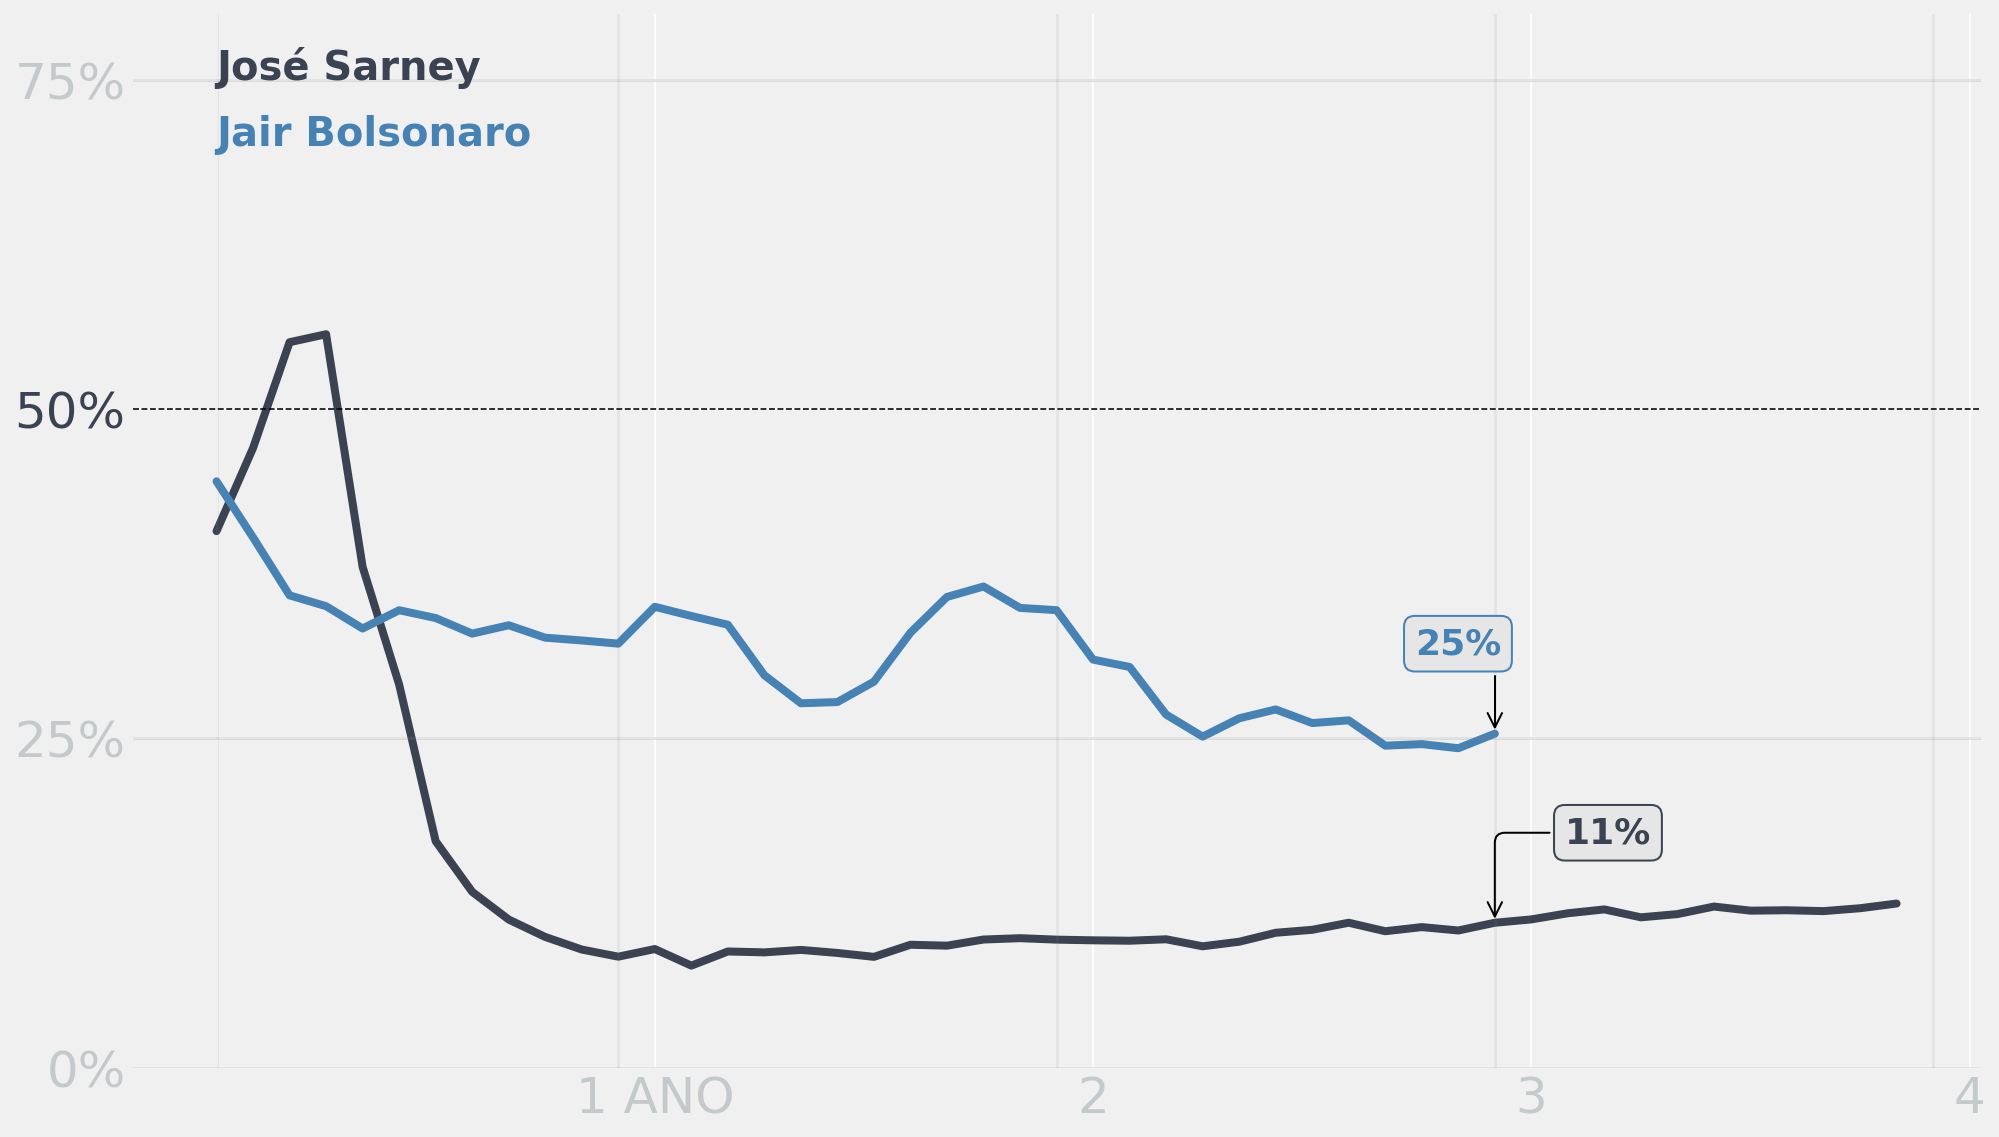

In [269]:
plot_static_curve("José Sarney")

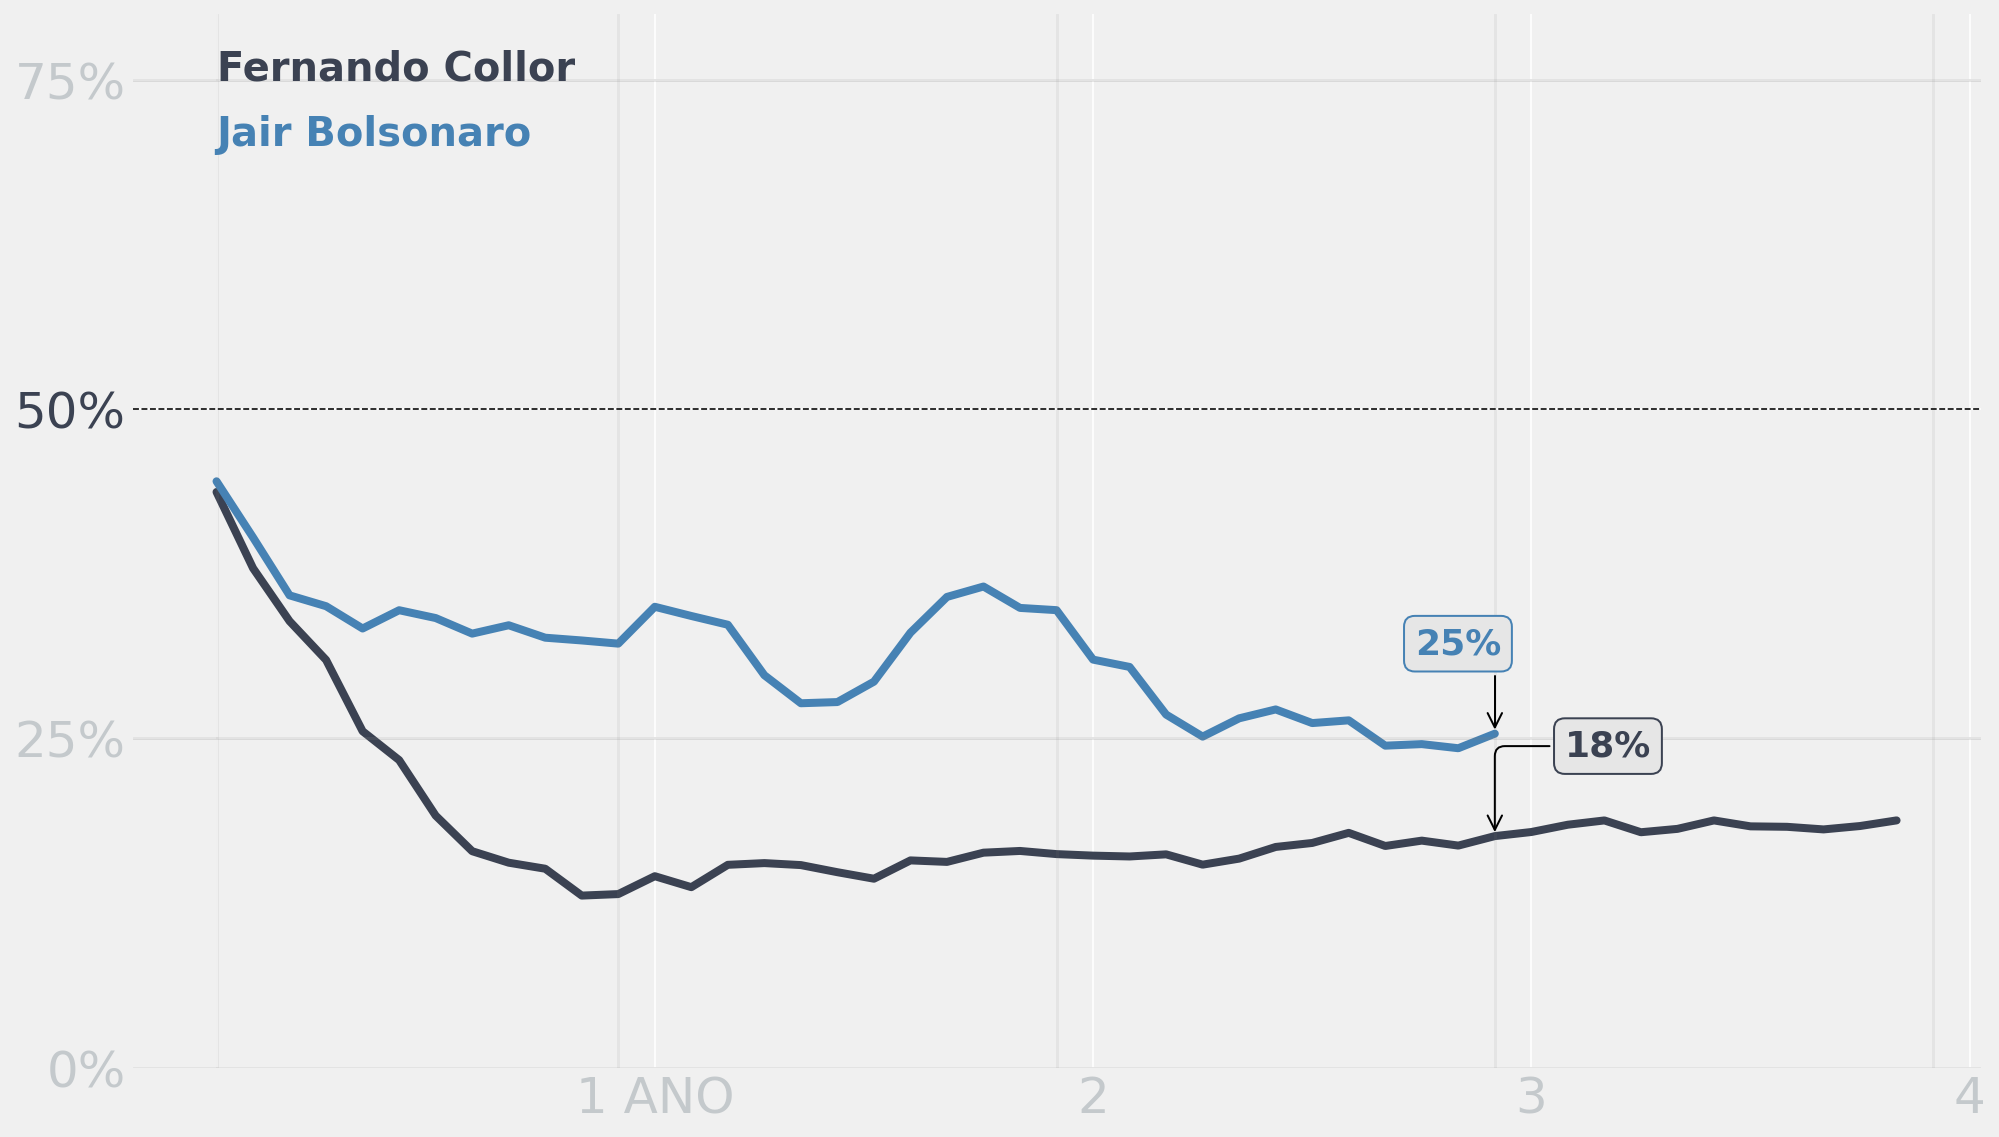

In [270]:
plot_static_curve("Fernando Collor")

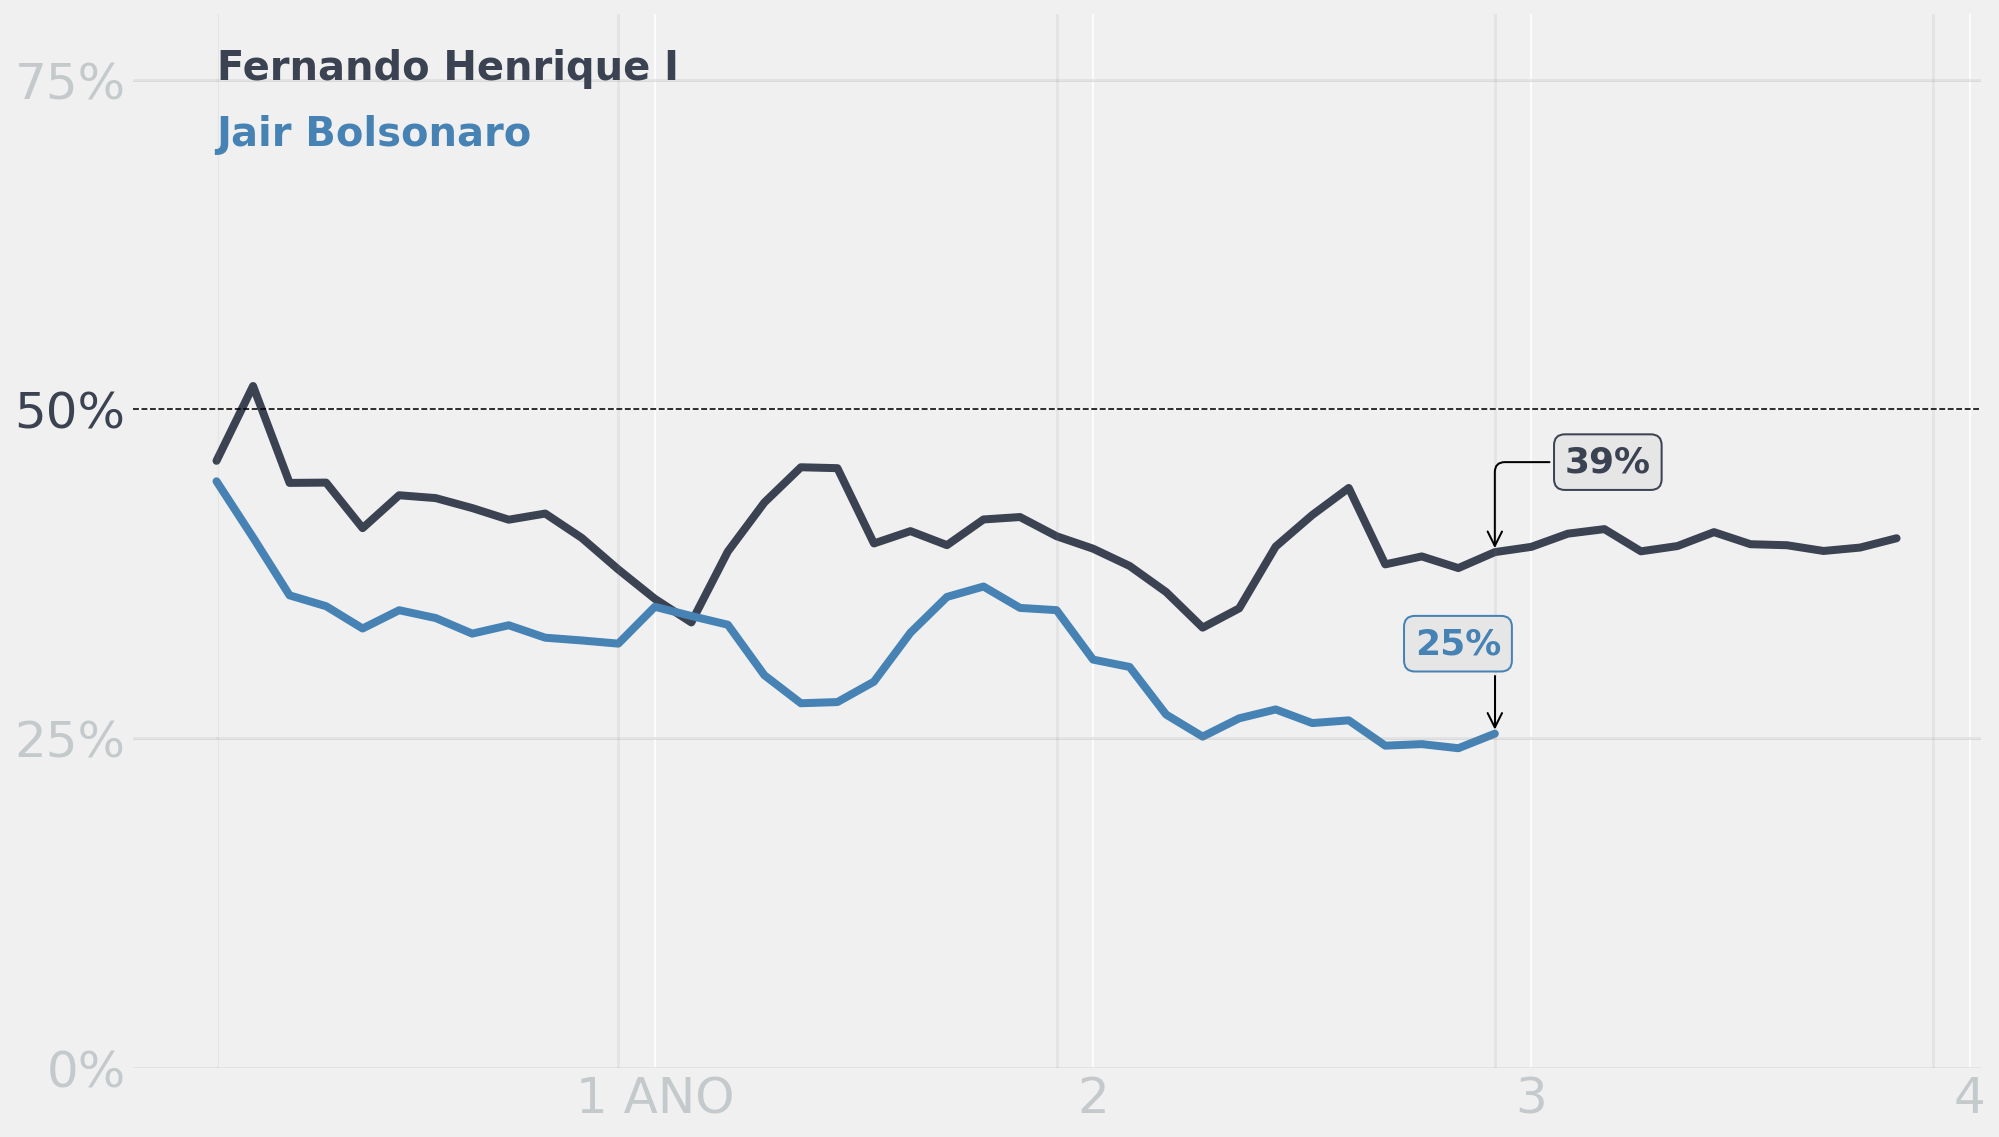

In [271]:
plot_static_curve("Fernando Henrique I")

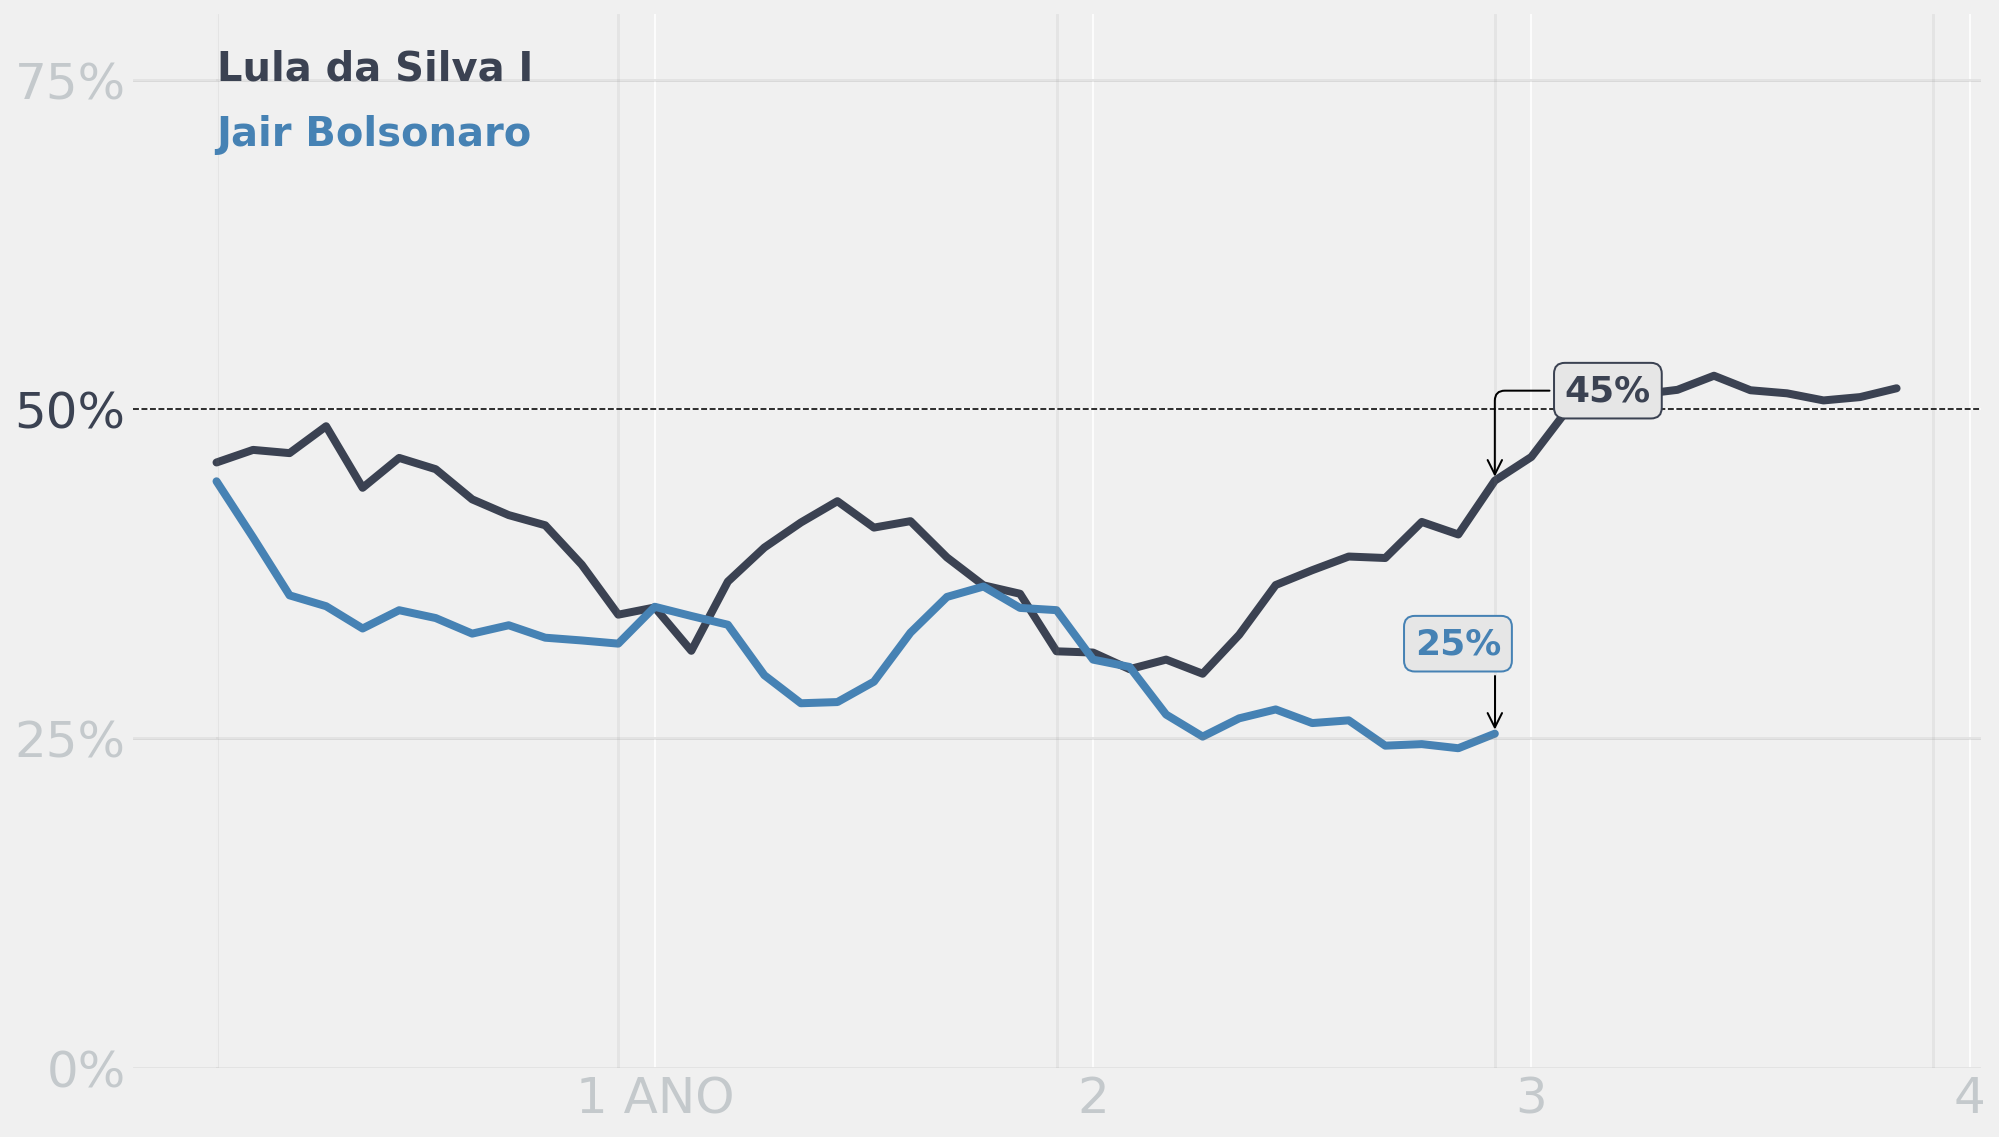

In [272]:
plot_static_curve("Lula da Silva I")

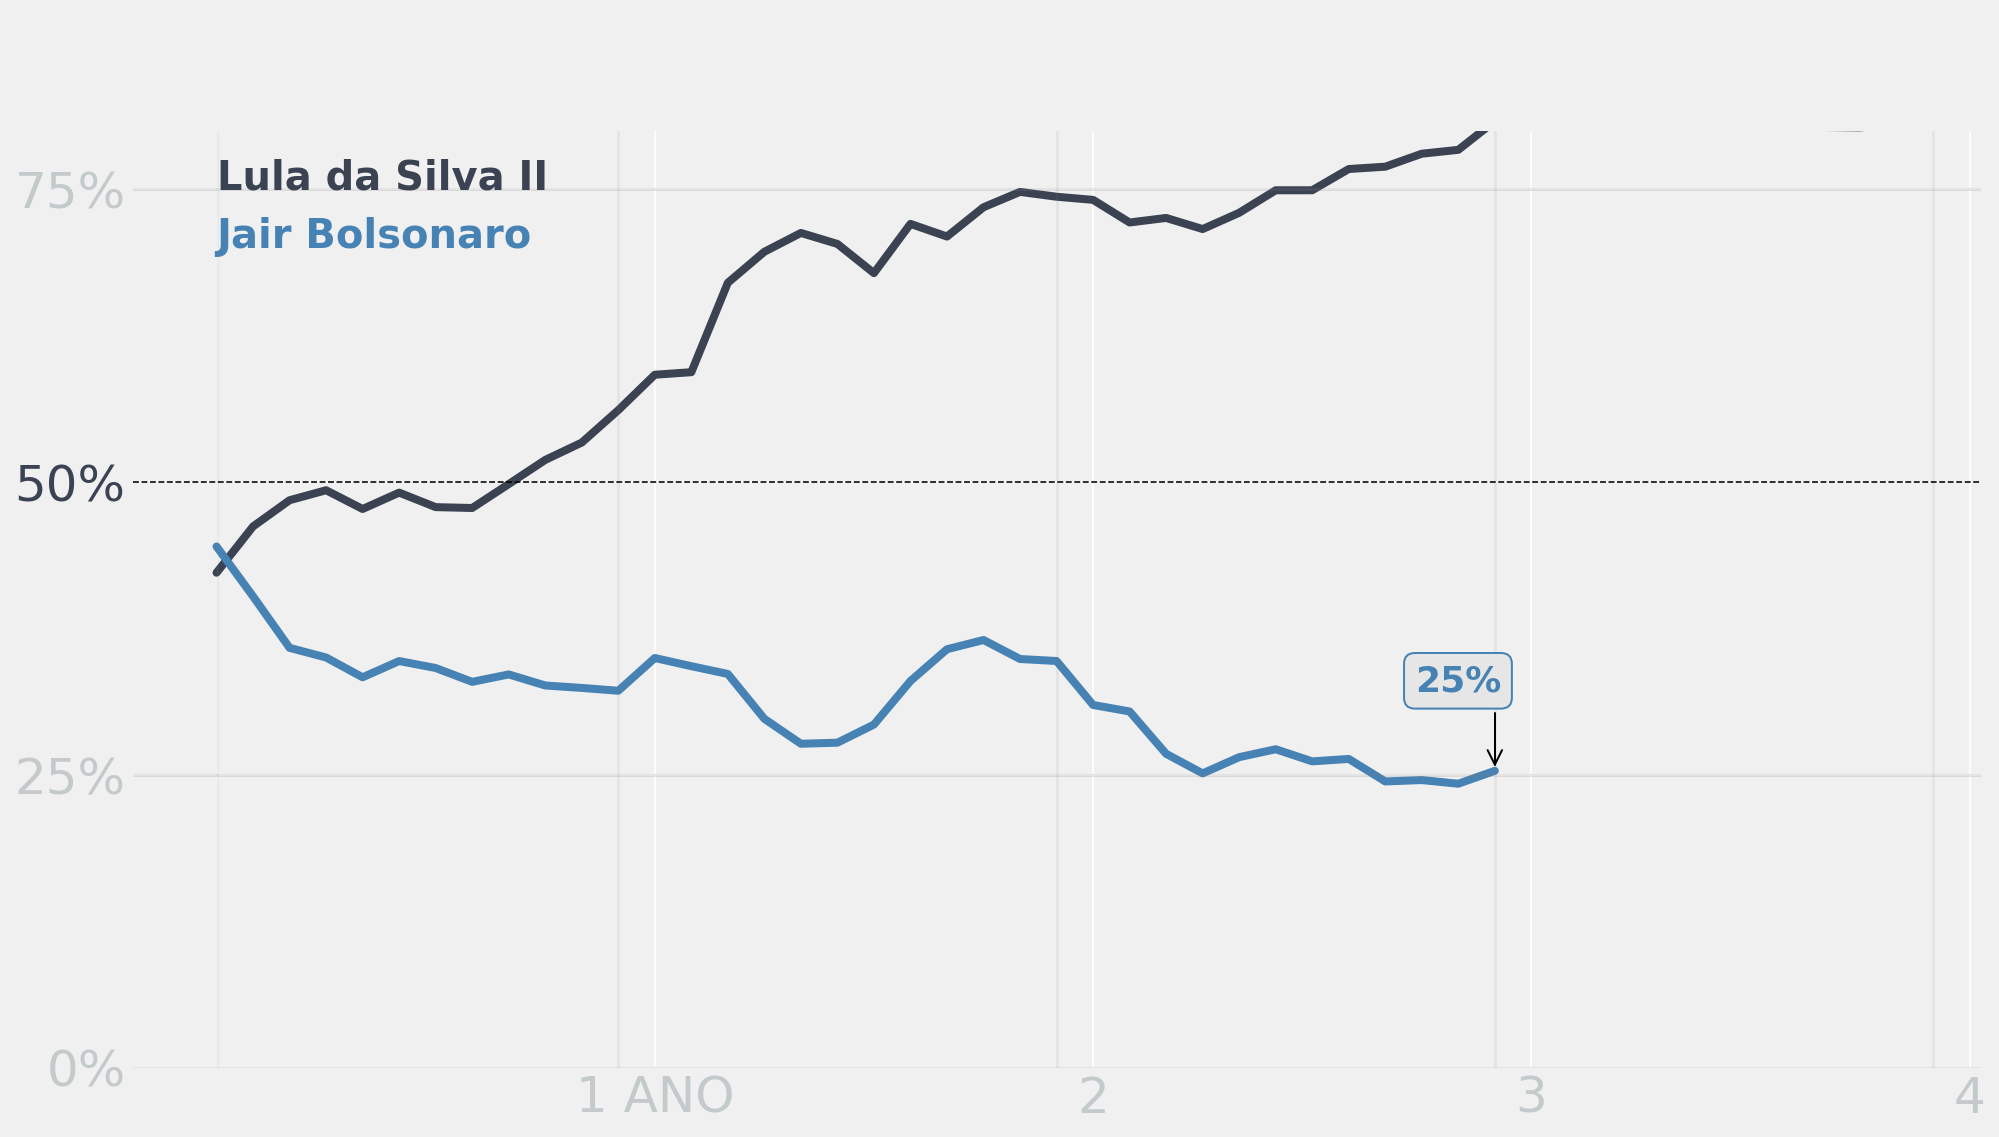

In [273]:
plot_static_curve("Lula da Silva II")

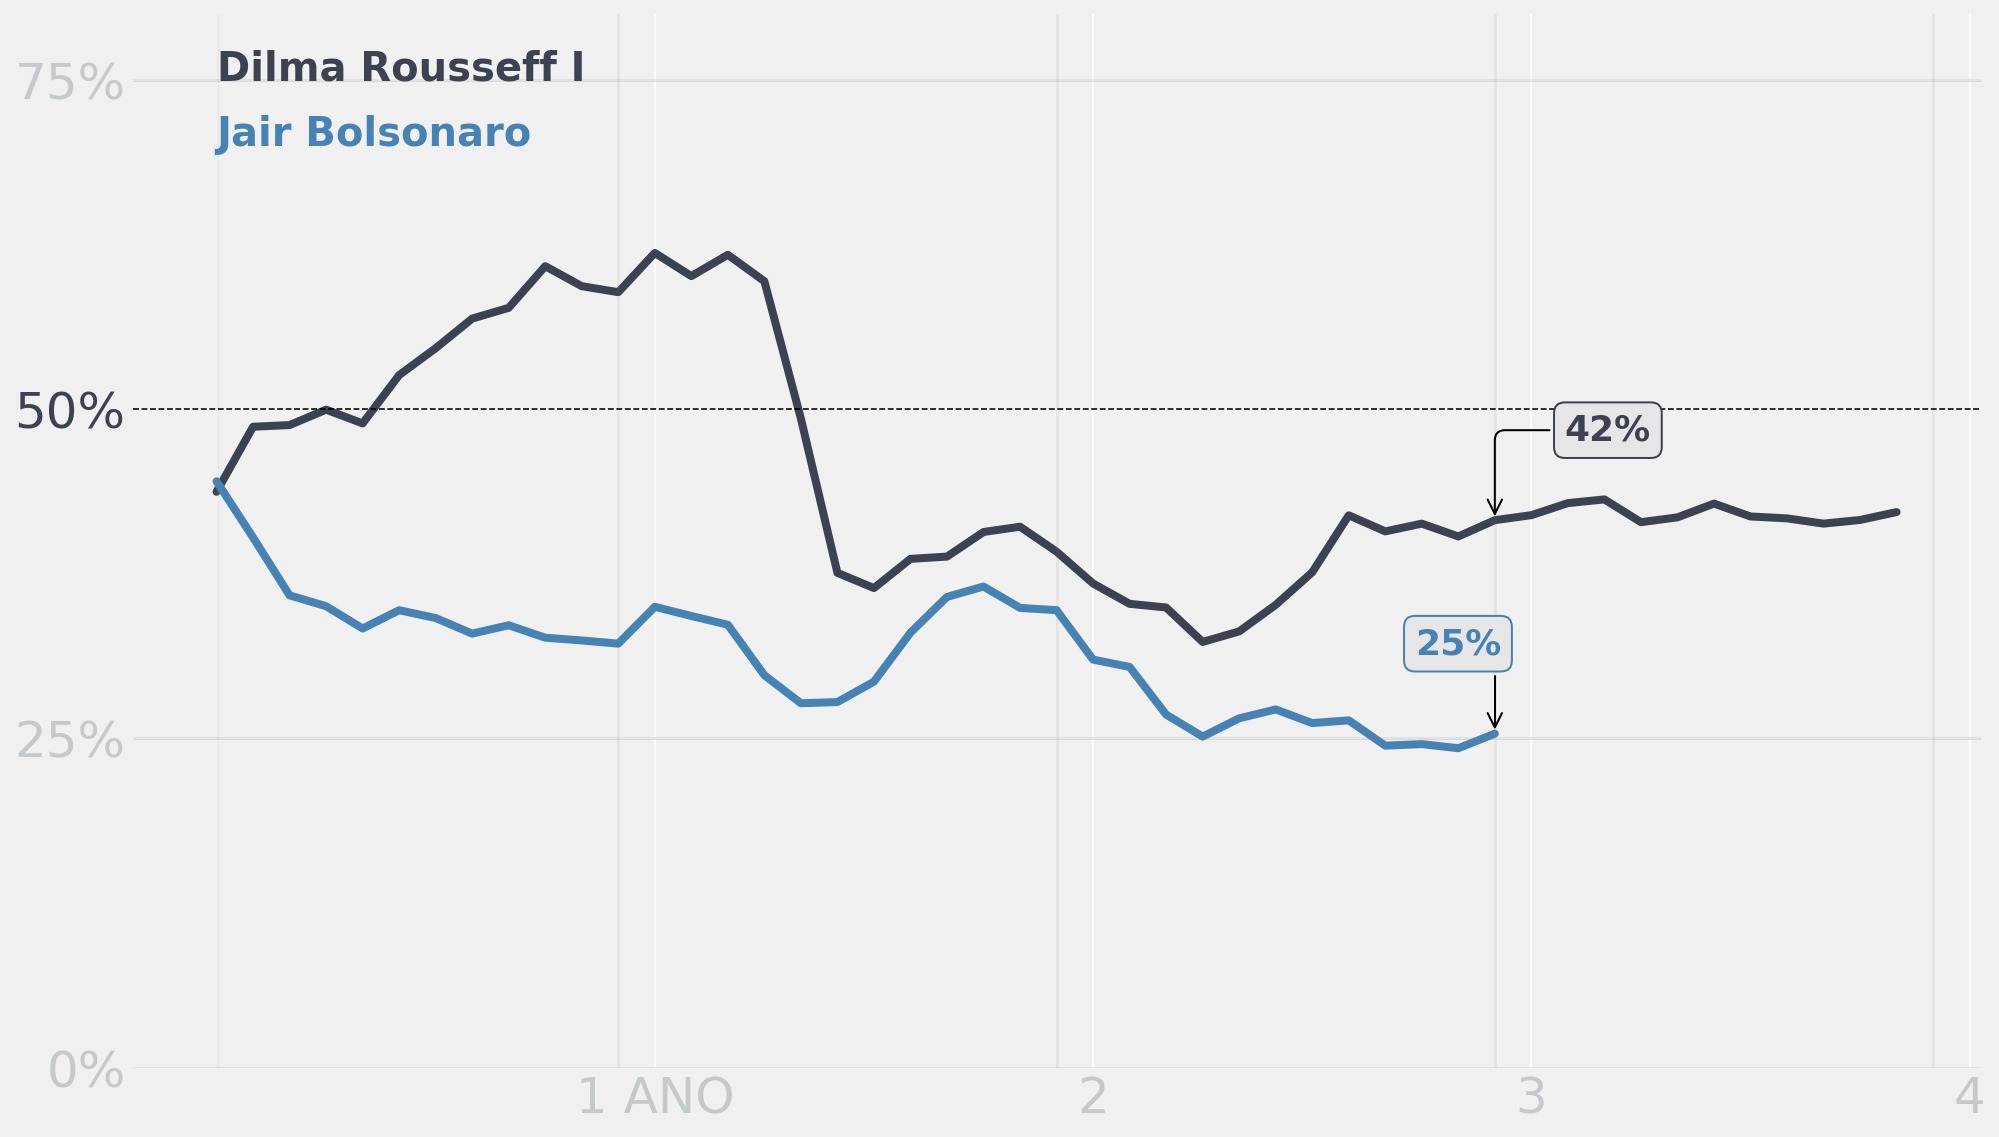

In [274]:
plot_static_curve("Dilma Rousseff I")

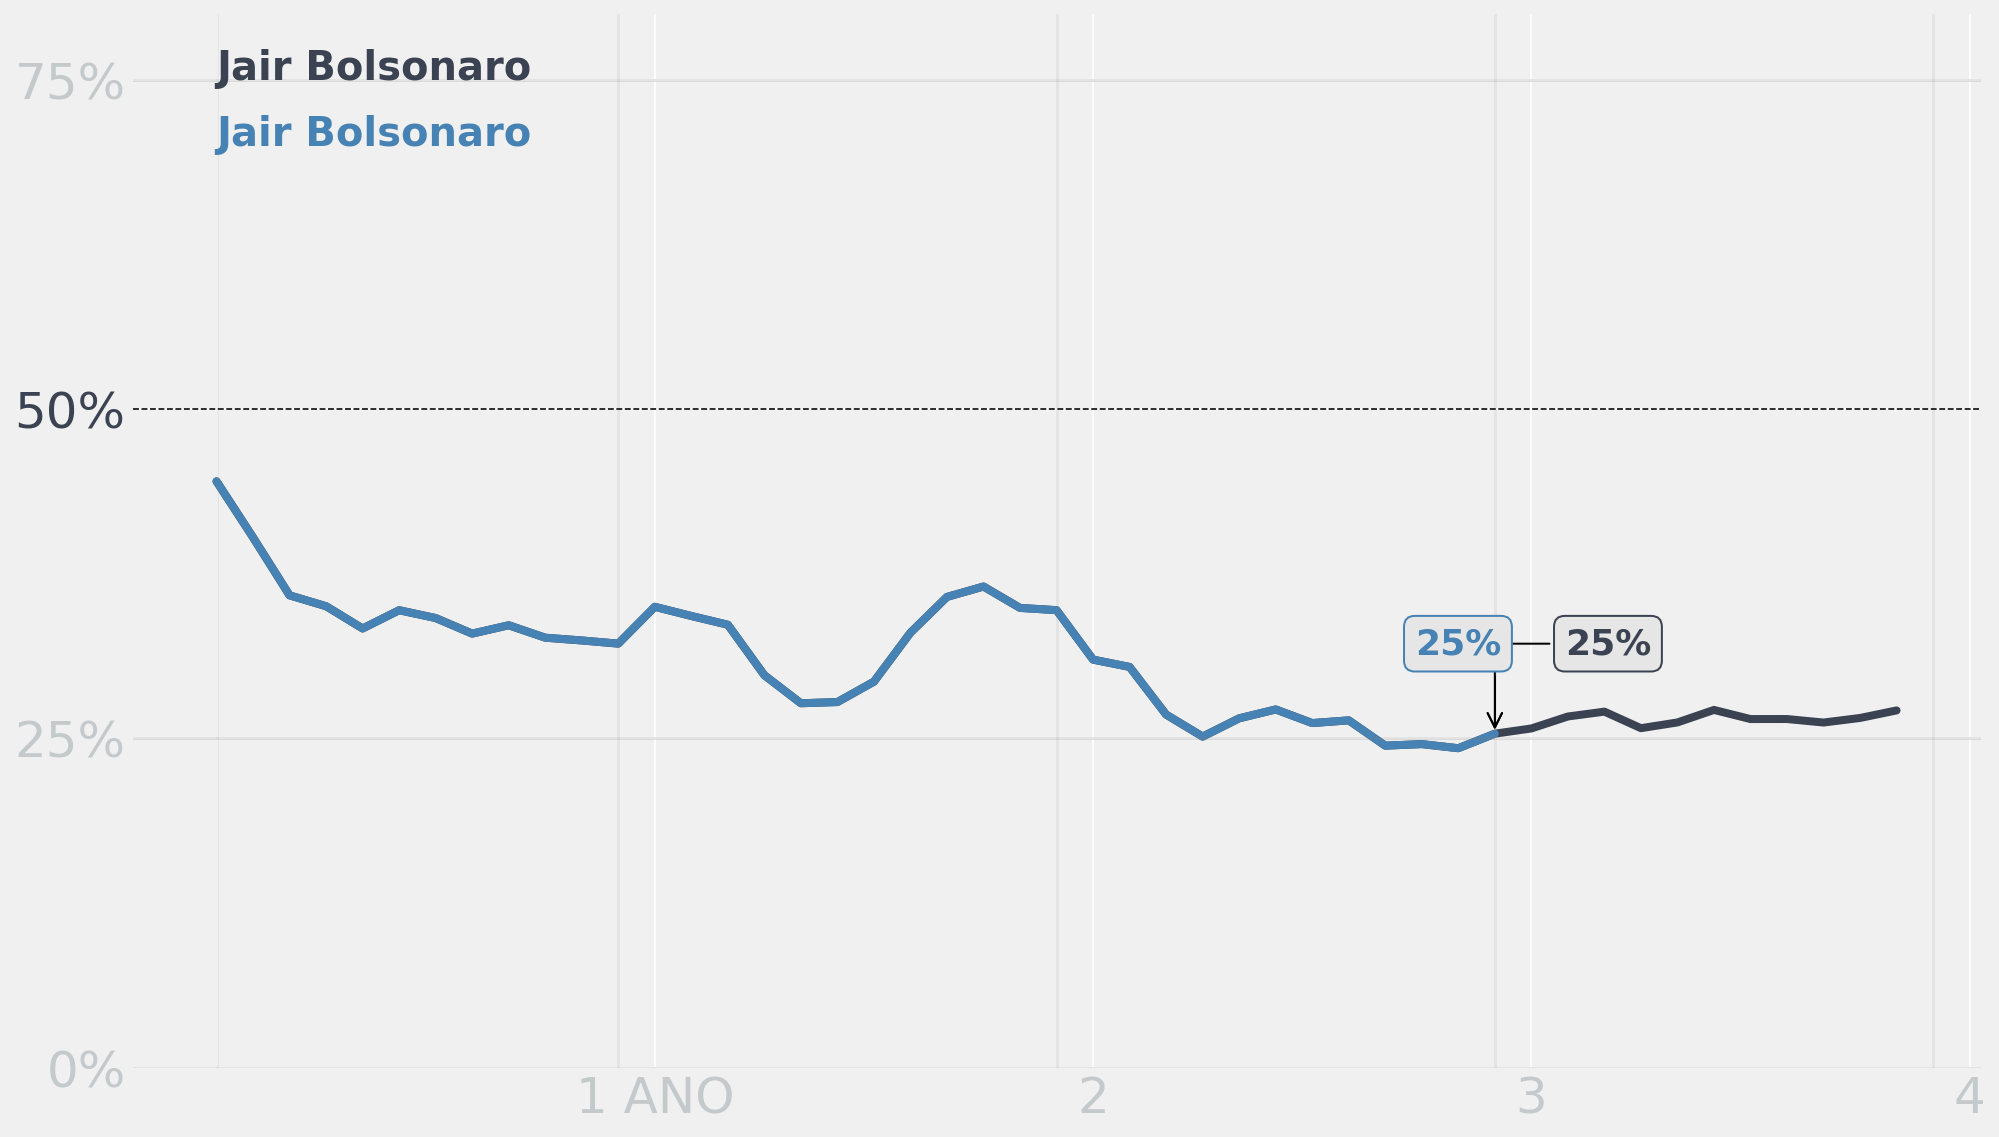

In [275]:
plot_static_curve("Jair Bolsonaro")

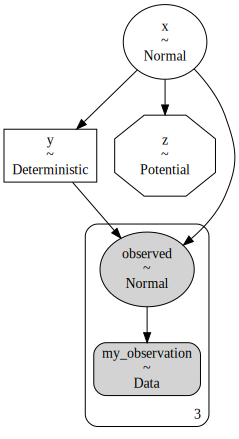

In [60]:
with pm.Model() as model:
    x = pm.Normal('x')
    y = pm.Deterministic('y', np.abs(x))
    pm.Potential('z', pm.Normal.dist().logp(x))
    observation = pm.Data('my_observation', [1, 2, 0])
    pm.Normal('observed', mu=x, sd=y, observed=observation)

pm.model_to_graphviz(model)

In [61]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Thu Dec 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.18.1

pymc3     : 3.11.4
pandas    : 1.2.2
sys       : 3.8.6 (default, Nov 20 2020, 18:29:40) 
[Clang 12.0.0 (clang-1200.0.32.27)]
sqlite3   : 2.6.0
watermark : 2.2.0
arviz     : 0.11.2
theano    : 1.1.2
matplotlib: 3.3.4
numpy     : 1.20.1
datetime  : 4.3
xarray    : 0.19.0
seaborn   : 0.11.1

